# Project M3: TicTacToe with Reinforcement Learning
Goal of this project is to use Reinforcement Learning algorithms in order to learn the game TicTacToe. 

A TicTacToe environment incl. its reward structure is implemented from scratch. The following algorithms are being implemented:
- Q-Learning with Tabular Q-Function
- Deep Q-Learning with Neural Network (DQN)
- SARSA with Neural Network
- REINFORCE with Neural Network
    
An agent playing X (i.e. player with first move) will be trained. Always with the goal, that the agent doesn't know the rules of the game beforehand (e.g. the agent doesn't know that he can't set X on a field which is already occupied).

Additionally, an interactive app to play against trained agents is created with Streamlit, to better understand the agents behaviour.

In [3]:
import numpy as np
import pandas as pd
import uuid
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.distributions import Categorical
from tqdm import tqdm

## 1. Determine the state space for Q-Table   
In the following section the state space is derived that is needed for the tabular Q-Function implementation. Every possible state of the TicTacToe game is captured and it is indicated for which player the state is relevant to take an action and if a state is a terminal state (Win X, Win O or Draw)

In [1]:
# A state is represented with an array of shape (3,3) and players are assigned the following values
# Player X = 1
# Player O = 2
# Empty field = 0

# A state can also be represented as an array of shape (3, 3, 3) with 3 rows and 3 columns and a third dimension for the player
# Players are represented with a vector of size 3 (like a one-hot encoded state):
# Player X = [1, 0, 0]
# Player O = [0, 1, 0]
# Empty field = [0, 0, 1]

In [4]:
example_state = np.array([
    [0, 2, 1],
    [1, 2, 1],
    [0, 2, 1]
])

example_state.shape

(3, 3)

In [5]:
def get_one_hot_state(state):
    
    state_one_hot = []

    for pos in state.flatten():

        if pos == 1:
            one_hot_pos = [1, 0, 0]
        elif pos == 2:
            one_hot_pos = [0, 1, 0]
        elif pos == 0:
            one_hot_pos = [0, 0, 1]

        state_one_hot.extend(one_hot_pos)

    return np.array(state_one_hot).flatten()

In [6]:
example_state_one_hot = get_one_hot_state(example_state)
example_state_one_hot

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0])

In [7]:
def print_state(state):

    printable_state = state.astype(str)

    printable_state = np.where(printable_state=='0', '-', printable_state)
    printable_state = np.where(printable_state=='1', 'X', printable_state)
    printable_state = np.where(printable_state=='2', 'O', printable_state)
        
    print(printable_state)

In [8]:
print_state(example_state)

[['-' 'O' 'X']
 ['X' 'O' 'X']
 ['-' 'O' 'X']]


In [9]:
# Set initial state
init_state = np.zeros(shape=(3,3), dtype='int')
print_state(init_state)

[['-' '-' '-']
 ['-' '-' '-']
 ['-' '-' '-']]


In [10]:
def evaluate_state(state, player, action):
    
    state_to_evaluate = state.reshape(3,3)
    
    # Win for player in a column
    for x in range(0,3):
        if state_to_evaluate[0][x] == action and state_to_evaluate[1][x] == action and state_to_evaluate[2][x] == action:
            return True, player

    # Win for player in a row
    for y in range(0,3):
        if state_to_evaluate[y][0] == action and state_to_evaluate[y][1] == action and state_to_evaluate[y][2] == action:
            return True, player

    # Win for player in diagonal from top left to bottom right
    if state_to_evaluate[0][0] == action and state_to_evaluate[1][1] == action and state_to_evaluate[2][2] == action:
            return True, player

    # Win for player in diagonal from bottom left to top right
    if state_to_evaluate[0][2] == action and state_to_evaluate[1][1] == action and state_to_evaluate[2][0] == action:
            return True, player
    
    # Open game
    if np.any(state_to_evaluate==0) == True:
        return False, 'Open'
    
    # Remis - all positions taken, but no Winner
    else:
        return True, 'Draw'

In [11]:
def determine_state_space(move, prev_states):
    
    states = []
    
    if move in [1, 3, 5, 7, 9]:
        player = 'X'
        action = 1
    else:
        player = 'O'
        action = 2
    
    # Special logic for init states and first moves
    if move == 0:
        
        state_data = {
            'uuid': str(uuid.uuid4()),
            'move': 0,
            'player': None,
            'state': prev_states,
            'terminal_state': False,
            'terminal_reason': 'Open',
            'prev_state_uuid': 0
        }
        
        states.append(state_data)
            
    else:
        
        for prev_state in prev_states:
            
            prev_state_uuid = prev_state['uuid']
            prev_state_terminal = prev_state['terminal_state']
            prev_state = prev_state['state']
            
            # Check further positions only if prev state is not terminated
            if prev_state_terminal == False:

                # Loop through positions base on prev_state
                for idx in range(len(prev_state)):

                    state = prev_state.copy()

                    # Only set position if position is empty
                    if state[idx] == 0:

                        state[idx] = action

                        # Check for terminal conditions after move
                        terminal_state, terminal_reason = evaluate_state(state, player, action)

                        state_data = {
                            'uuid': str(uuid.uuid4()),
                            'move': move,
                            'player': player,
                            'state': state,
                            'terminal_state': terminal_state,
                            'terminal_reason': terminal_reason,
                            'prev_state_uuid': prev_state_uuid
                        }

                        states.append(state_data)
        
    return states

In [12]:
states_all = []

# Set initial state
init_state = np.zeros(shape=(3,3), dtype='int')

# Iterate through moves 1-9 and include move 0, i.e. init-position
for move in range(10):
    
    if move == 0:
        states = determine_state_space(move, init_state.flatten())
    else:
        states = determine_state_space(move, states)
    
    # Iterate through states and add single states to all-list
    for state in states:
        states_all.append(state)

In [13]:
df_states_all = pd.DataFrame(states_all)
df_states_all.head()

uuid  move player  \
0  d47f890d-d58e-4e0d-89db-3519c2f26a70     0   None   
1  1364449f-38d8-49d9-b514-87eae8fad6aa     1      X   
2  ffab01cd-ce06-49c0-873b-c9dbdc4ce146     1      X   
3  0b1e4873-56b8-44b8-b7f8-2b3d1fda81a9     1      X   
4  5bd230d7-8557-410f-afe6-93fcd59bf690     1      X   

                         state  terminal_state terminal_reason  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0]           False            Open   
1  [1, 0, 0, 0, 0, 0, 0, 0, 0]           False            Open   
2  [0, 1, 0, 0, 0, 0, 0, 0, 0]           False            Open   
3  [0, 0, 1, 0, 0, 0, 0, 0, 0]           False            Open   
4  [0, 0, 0, 1, 0, 0, 0, 0, 0]           False            Open   

                        prev_state_uuid  
0                                     0  
1  d47f890d-d58e-4e0d-89db-3519c2f26a70  
2  d47f890d-d58e-4e0d-89db-3519c2f26a70  
3  d47f890d-d58e-4e0d-89db-3519c2f26a70  
4  d47f890d-d58e-4e0d-89db-3519c2f26a70

In [14]:
# The number of states is so high because many states after n-moves are duplicated because they can result from different move combinations (i.e. game paths)
# E.g. [1, 2, 1, 2, 0, 0, 0, 0, 0] can result from following previous states
# State 1: [1, 2, 1, 0, 0, 0, 0, 0]
# State 2: [1, 0, 1, 2, 0, 0, 0, 0]
# i.e. every state after move 4 can results from two different previous states!!!
# Since in RL the MDP holds, we don't distinguish between paths that lead to a certain state and we can drop duplicates
df_states_all.count()

uuid               549946
move               549946
player             549945
state              549946
terminal_state     549946
terminal_reason    549946
prev_state_uuid    549946
dtype: int64

In [15]:
# Remove duplicate stats
df_states_unique = df_states_all[df_states_all['state'].map(tuple).duplicated(keep='first')==False]
df_states_unique

uuid  move player  \
0       d47f890d-d58e-4e0d-89db-3519c2f26a70     0   None   
1       1364449f-38d8-49d9-b514-87eae8fad6aa     1      X   
2       ffab01cd-ce06-49c0-873b-c9dbdc4ce146     1      X   
3       0b1e4873-56b8-44b8-b7f8-2b3d1fda81a9     1      X   
4       5bd230d7-8557-410f-afe6-93fcd59bf690     1      X   
...                                      ...   ...    ...   
451390  4cf2573f-85bf-47fa-aae6-c4272ef6ca20     9      X   
451395  446ab039-68a5-4bbc-ac0a-d716577dc6b0     9      X   
451604  4b904f9c-9d09-4f1f-969b-18bc176b106a     9      X   
467510  76314ce6-fd46-4a54-ae9c-ab2f5082babc     9      X   
480159  eb7a36e7-b3b7-484b-a76c-1a736862490e     9      X   

                              state  terminal_state terminal_reason  \
0       [0, 0, 0, 0, 0, 0, 0, 0, 0]           False            Open   
1       [1, 0, 0, 0, 0, 0, 0, 0, 0]           False            Open   
2       [0, 1, 0, 0, 0, 0, 0, 0, 0]           False            Open   
3       [0, 0, 1, 0, 0, 0, 0, 0, 0]           False            Open   
4       [0, 0, 0, 1, 0, 0, 0, 0, 0]           False            Open   
...                             ...             ...             ...   
451390  [2, 2, 1, 2, 1, 1, 1, 1, 2]            True               X   
451395  [2, 2, 1, 2, 1, 2, 1, 1, 1]            True               X   
451604  [2, 2, 1, 2, 2, 1, 1, 1, 1]            True               X   
467510  [1, 2, 2, 1, 1, 2, 1, 2, 1]            True               X   
480159  [2, 2, 1, 2, 1, 1, 1, 2, 1]            True               X   

                             prev_state_uuid  
0                                          0  
1       d47f890d-d58e-4e0d-89db-3519c2f26a70  
2       d47f890d-d58e-4e0d-89db-3519c2f26a70  
3       d47f890d-d58e-4e0d-89db-3519c2f26a70  
4       d47f890d-d58e-4e0d-89db-3519c2f26a70  
...                                      ...  
451390  e284e554-2597-4fd9-a020-524cc1edb7ec  
451395  5adb6352-6bac-41e4-b87d-857730c59e3a  
451604  2aaf846f-44bb-42a1-8c77-17733155c05e  
467510  7577c2ee-bf3f-41be-a4be-3959ff12c302  
480159  6ef6720e-a977-43bf-8f60-1fe204b17571  

[5478 rows x 7 columns]

In [16]:
# Unique tictactoe boards after number of moves (without accounting for rotation/mirroring)
# That means our Q-Table will have 5478 entries in total
# This corresponds with the values published on https://math.stackexchange.com/questions/469371/determining-the-number-of-valid-tictactoe-board-states-in-terms-of-board-dimensi
df_states_unique.groupby('move')['uuid'].count()

move
0       1
1       9
2      72
3     252
4     756
5    1260
6    1520
7    1140
8     390
9      78
Name: uuid, dtype: int64

In [17]:
# When only considering stats upon player X has to act and state is not terminal, then we have 2423 states (i.e. show all state combinations where player X didn't act)
df_states_unique[(df_states_unique['player']!='X') & (df_states_unique['terminal_state']==False)].groupby('move')['uuid'].count()

move
0       1
2      72
4     756
6    1372
8     222
Name: uuid, dtype: int64

In [18]:
# Total number of non-terminated unique boards where player X has to act (i.e. where Player O was the player who moved before)
df_states_unique[(df_states_unique['player']!='X') & (df_states_unique['terminal_state']==False)]['uuid'].count()

2423

In [19]:
# Total number of non-terminated unique boards where player 0 has to act
df_states_unique[(df_states_unique['player']!='O') & (df_states_unique['terminal_state']==False)]['uuid'].count()

2098

In [20]:
states_unique_arr = np.array(list(df_states_unique['state'].values))
states_unique_arr.shape

(5478, 9)

In [21]:
# Create a dict with all unique state and index them -> the index in dict corresponds to index of state in q-table later on
states_unique_dict = {idx:list(state) for idx, state in enumerate(states_unique_arr)}
states_unique_dict

{0: [0, 0, 0, 0, 0, 0, 0, 0, 0],
 1: [1, 0, 0, 0, 0, 0, 0, 0, 0],
 2: [0, 1, 0, 0, 0, 0, 0, 0, 0],
 3: [0, 0, 1, 0, 0, 0, 0, 0, 0],
 4: [0, 0, 0, 1, 0, 0, 0, 0, 0],
 5: [0, 0, 0, 0, 1, 0, 0, 0, 0],
 6: [0, 0, 0, 0, 0, 1, 0, 0, 0],
 7: [0, 0, 0, 0, 0, 0, 1, 0, 0],
 8: [0, 0, 0, 0, 0, 0, 0, 1, 0],
 9: [0, 0, 0, 0, 0, 0, 0, 0, 1],
 10: [1, 2, 0, 0, 0, 0, 0, 0, 0],
 11: [1, 0, 2, 0, 0, 0, 0, 0, 0],
 12: [1, 0, 0, 2, 0, 0, 0, 0, 0],
 13: [1, 0, 0, 0, 2, 0, 0, 0, 0],
 14: [1, 0, 0, 0, 0, 2, 0, 0, 0],
 15: [1, 0, 0, 0, 0, 0, 2, 0, 0],
 16: [1, 0, 0, 0, 0, 0, 0, 2, 0],
 17: [1, 0, 0, 0, 0, 0, 0, 0, 2],
 18: [2, 1, 0, 0, 0, 0, 0, 0, 0],
 19: [0, 1, 2, 0, 0, 0, 0, 0, 0],
 20: [0, 1, 0, 2, 0, 0, 0, 0, 0],
 21: [0, 1, 0, 0, 2, 0, 0, 0, 0],
 22: [0, 1, 0, 0, 0, 2, 0, 0, 0],
 23: [0, 1, 0, 0, 0, 0, 2, 0, 0],
 24: [0, 1, 0, 0, 0, 0, 0, 2, 0],
 25: [0, 1, 0, 0, 0, 0, 0, 0, 2],
 26: [2, 0, 1, 0, 0, 0, 0, 0, 0],
 27: [0, 2, 1, 0, 0, 0, 0, 0, 0],
 28: [0, 0, 1, 2, 0, 0, 0, 0, 0],
 29: [0, 0, 1, 0, 2, 0, 

In [22]:
def get_state_idx(state):
    idx = [k for k, v in states_unique_dict.items() if v == state] 
    return idx[0]

In [23]:
get_state_idx([0, 0, 2, 0, 2, 1, 1, 0, 0])

998

In [24]:
# The Q-Table with this approach has the shape (5478, 9)
# Index in first dimension corresponds to index in state_dict
# Last dimension is for the Q-values of the 9 possible actions
Q = np.zeros(shape=(len(states_unique_dict), 9), dtype='int')
Q.shape

(5478, 9)

In [25]:
# E.g. set Q-Value of an action for an example state
example_state = [0, 0, 2, 0, 2, 1, 1, 0, 0] # here as list
idx = get_state_idx(example_state)
Q[idx][0] = 100 # Value of action 1 for state with index idx
Q[idx]

array([100,   0,   0,   0,   0,   0,   0,   0,   0])

In [26]:
# Metadata for this state can be read from the dataframe of unique states (-> this was the basis for the array/dict)
df_states_unique.iloc[idx]

uuid               ae79fb07-daac-4593-82f6-48fb6cf18cbe
move                                                  4
player                                                O
state                       [0, 0, 2, 0, 2, 1, 1, 0, 0]
terminal_state                                    False
terminal_reason                                    Open
prev_state_uuid    4a03bfef-a6f6-4bb1-8dce-9bb6a0b68199
Name: 2377, dtype: object

In [26]:
# Alternative approach for Q-Table could be:
# Use an array with shape (3, 3, 3, 3, 3, 3, 3, 3, 3, 9)
# The index of the first 9 dimensions indicate if position is empty (index=0), player 1 (index=1) or player 2 (index=2)
# Last dimension is for the Q-values of the 9 possible actions

## 2. TicTacToe Environment and Tabular Q-Learning

When dealing with a two player game as TicTacToe, three main questions arise regarding its implementation with RL algorithms:
1. What is the next state/action pair?
2. How can a loss be feeded back?
3. When are the Q-Values (or the Policy Network for REINFORCE) being updated?

#### What is the next state/action pair?

SARSA and Q-Learning (Tabular and Deep-Q-Learning) are Temporal Difference Learning algorithms and the Bellman equation used in these algorithms requires to determine a Q-Value for the next state/action pair to assign a Q-Value to the current state/action pair. Since TicTacToe is played alternating between Player 1 and Player 2, the question arises what the next state/action pair from the perspective of a player is? Two possible options are visualised below.

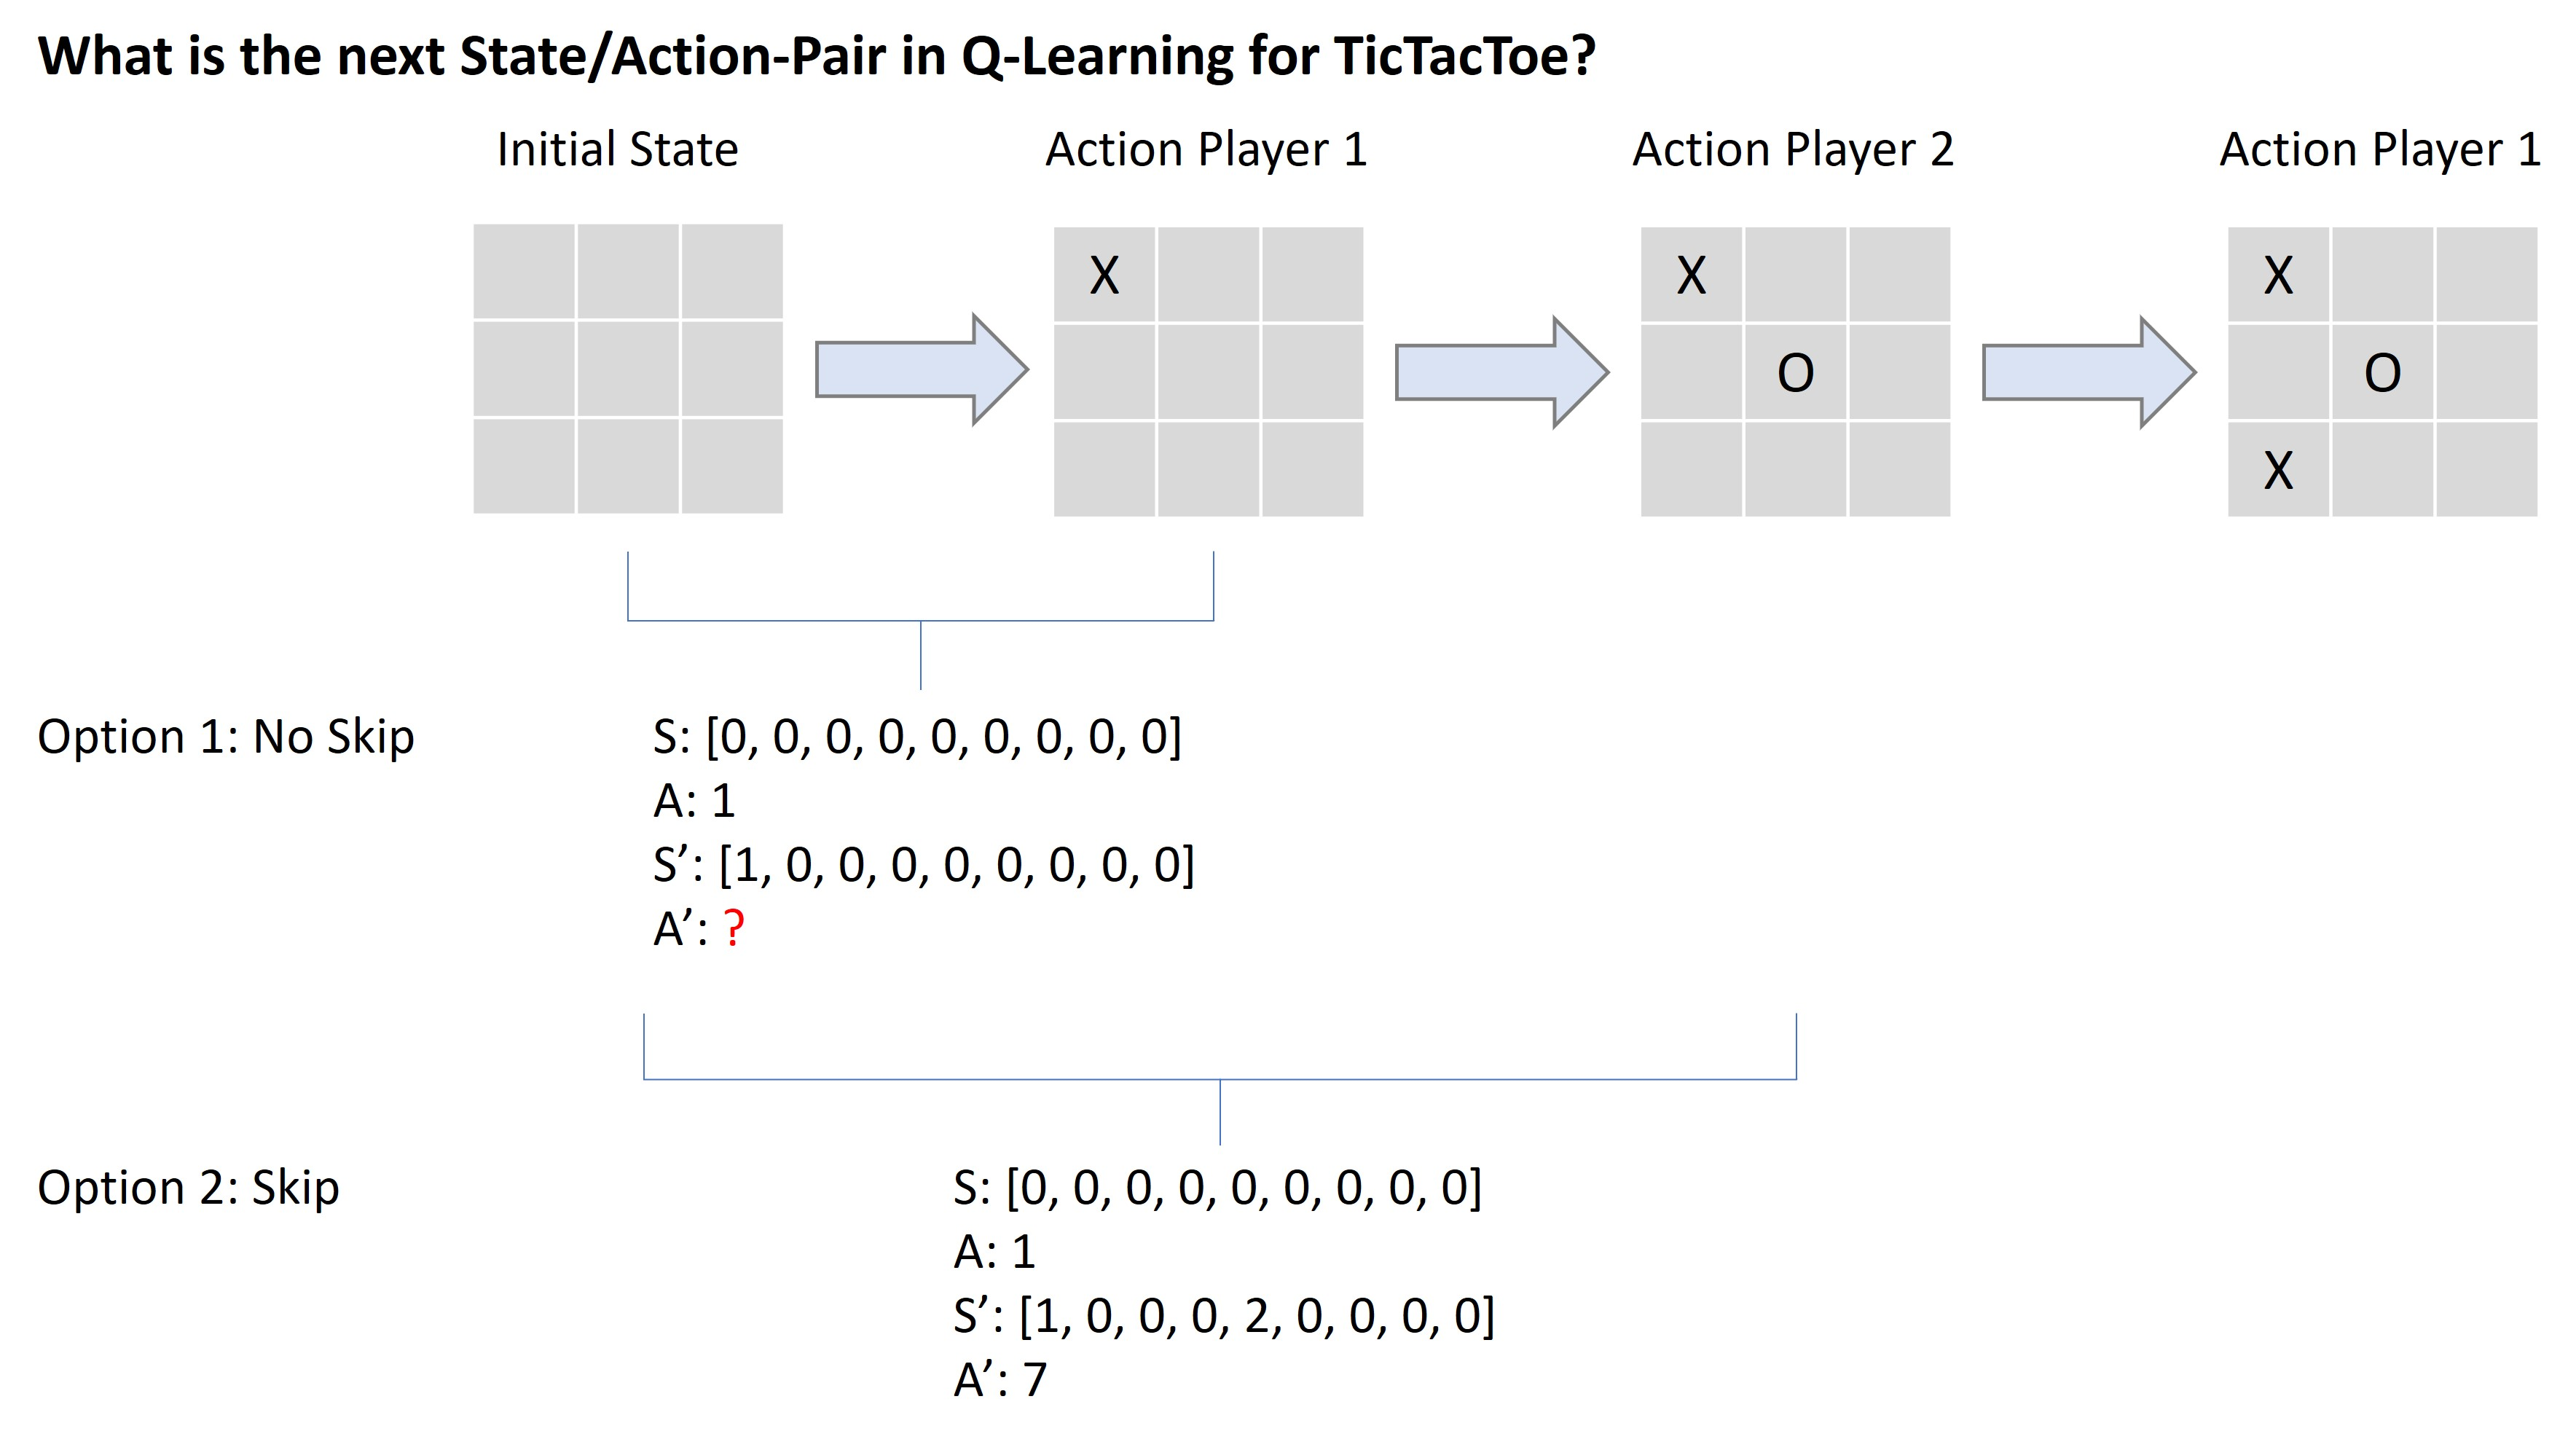

Option 1:  
In Option 1, the next state/action pair is based on the state right after the move of Player 1. The problem here is, that this state is not a state upon which Player 1 can take action. Instead, Player 2 is required to take an action. Therefore it is unclear, what the next action would be in this case.

Option 2:   
In Option 2, only the states which are relevant to Player 1 are considered as next states. And the next action can be determined as well. This option basicaly sees Player 2 as part of the environment, where Player 2 follows a fixed policy (e.g. playing random all the time). Having a random Player 2 player as part of the environment directly helps Player 1, to be confronted with all possible states upon which he has to act.

References:
- https://stackoverflow.com/questions/49451366/q-learning-applied-to-a-two-player-game
- https://ai.stackexchange.com/questions/10479/what-is-the-next-state-for-a-two-player-board-game

#### How can a loss be feeded back?
For a player to learn the game of TicTacToe a loss needs to be feeded back. As for humans, the quality of ones moves in a two player game needs to take the action of the opponent player into consideration. Since Player 1 can't loss a game only with his moves (only a win or a draw is possible), the moves of Player 2 (and the resulting state) have to be feeded back to Player 1.

This requirement fits with the above disussed Option 2, to only consider states after the opponents move as next states.

Below illustration again shows, how a Player 1 loss is feeded back as a negative rewards (Option 2 - Delay reward by 1 step if Player 2 can still move). When the reward is not delayed (Option 1), a loss would never be feeded back.

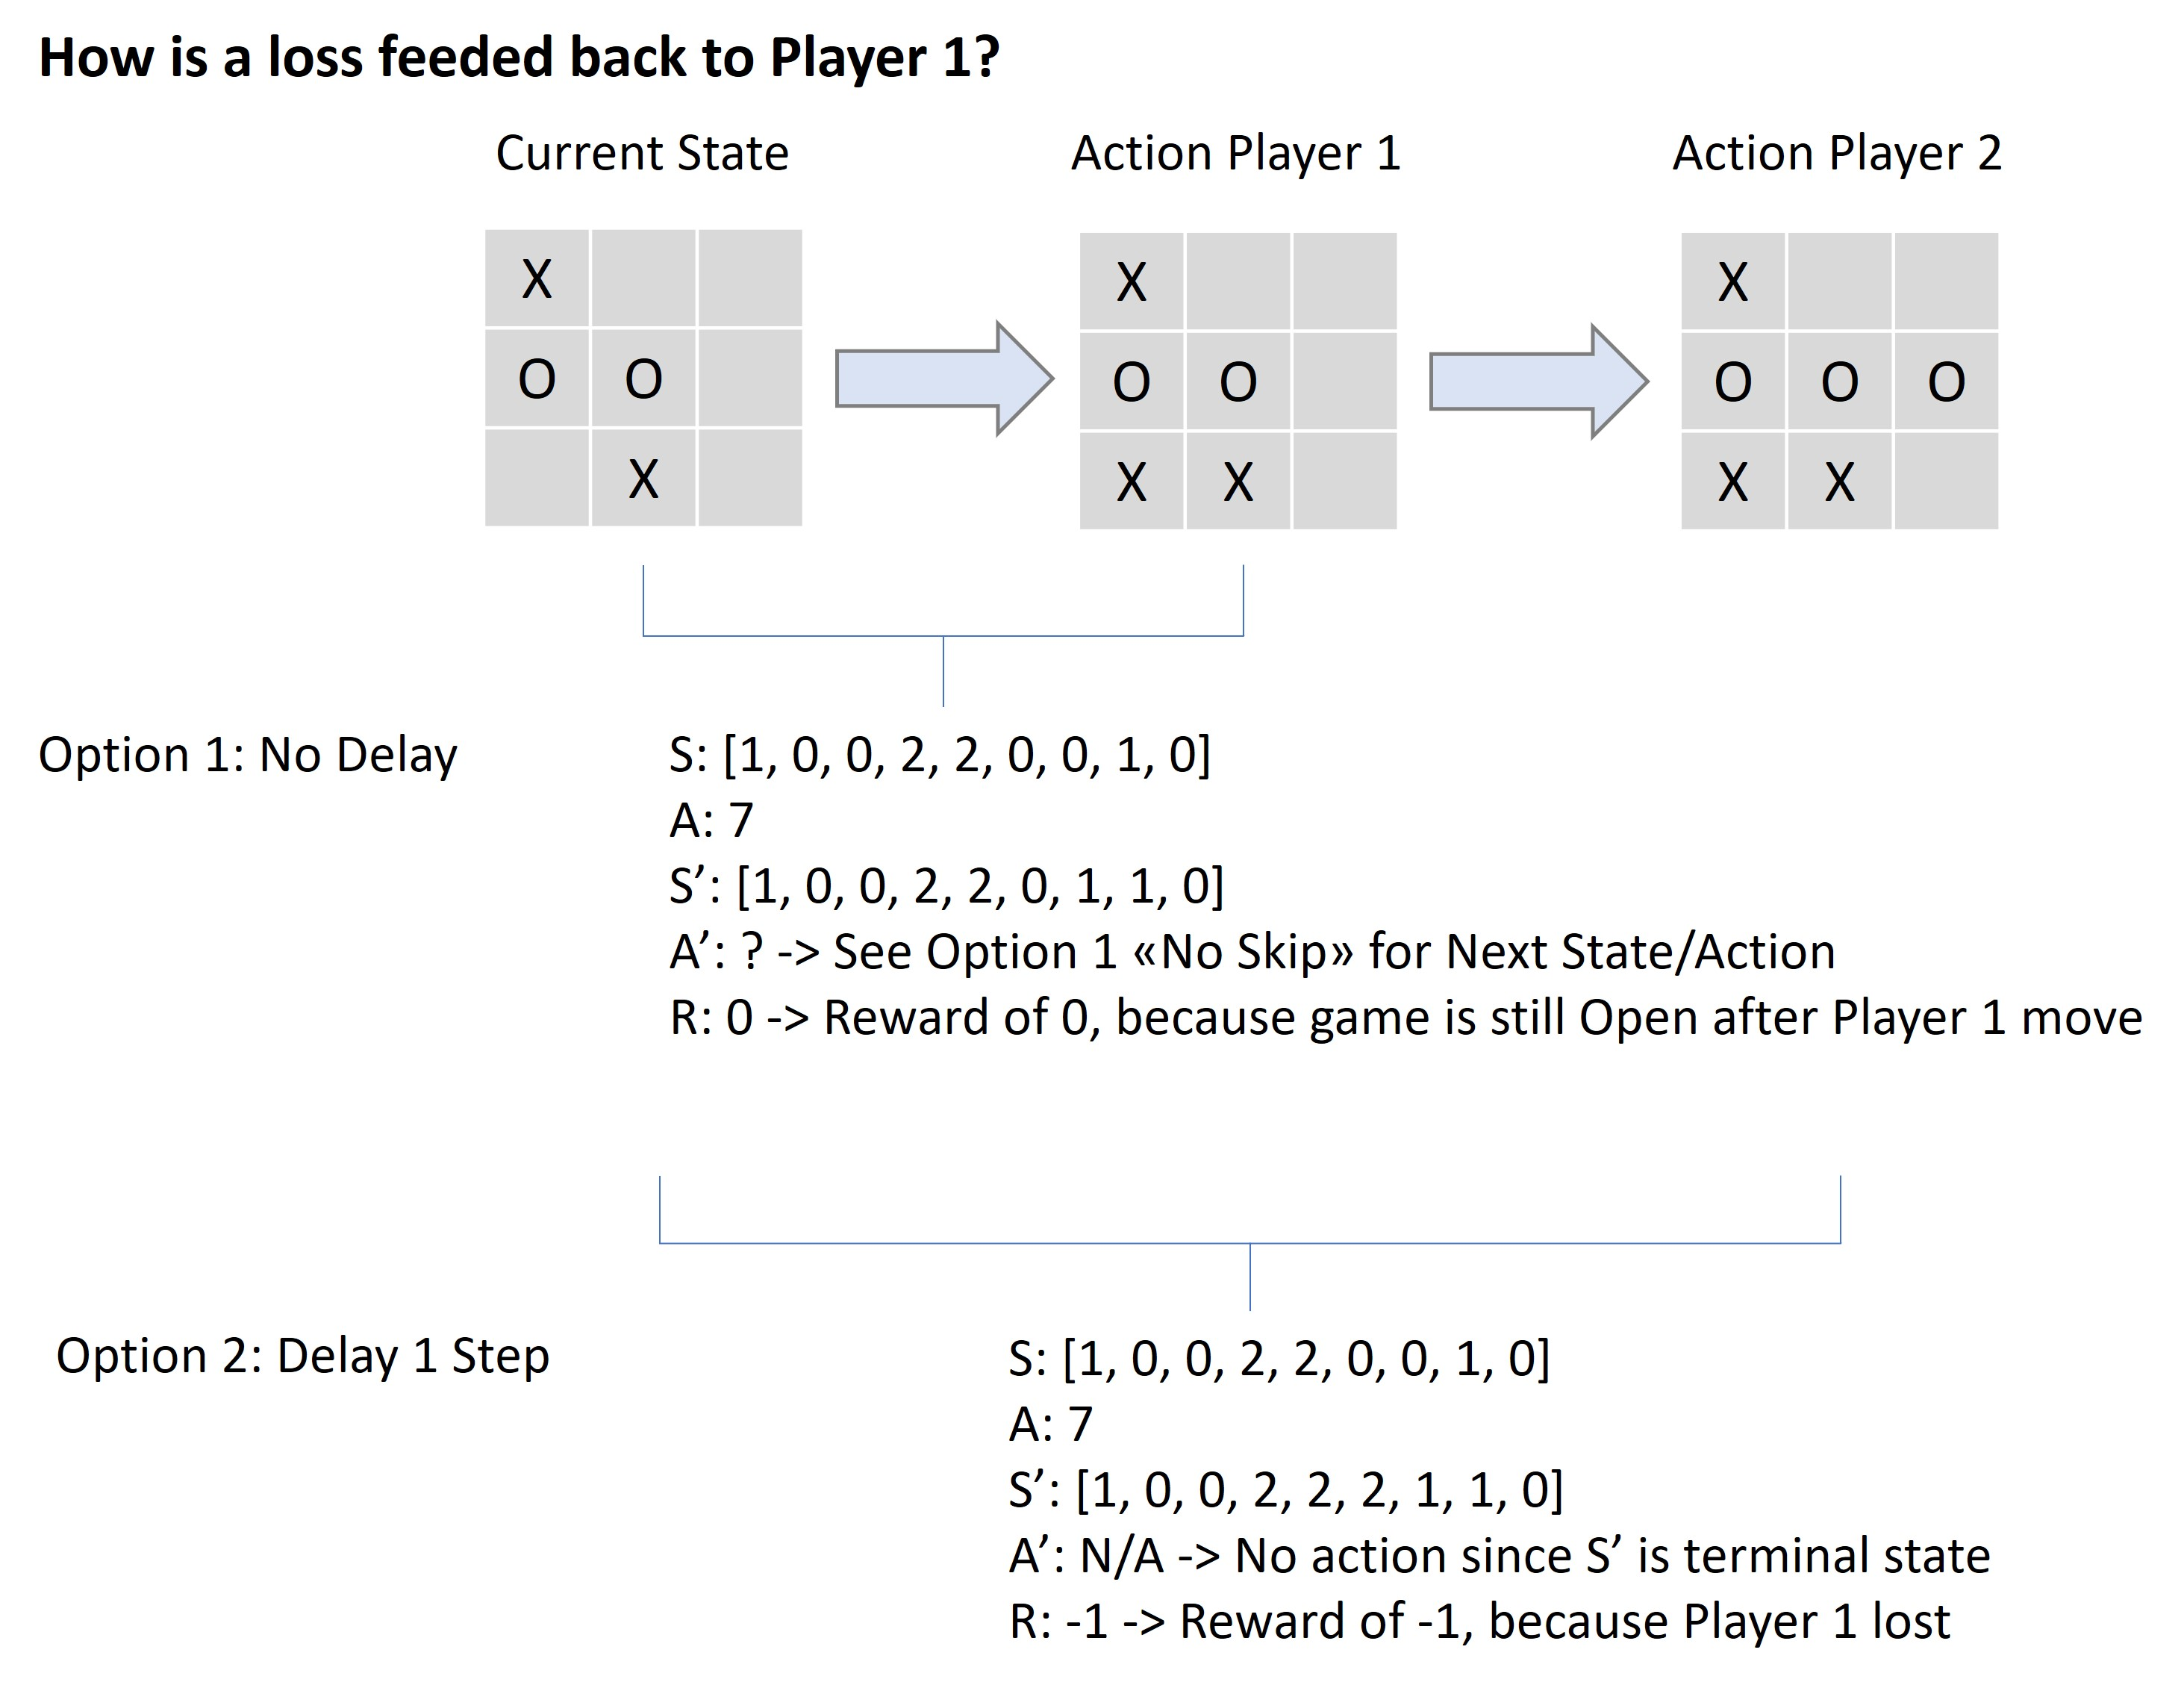

#### When are the Q-Values being updated?
The core of SARSA and Q-Learning is to update the Q-Values for each state/action pair. There are mainly two options to achieve this:
1. After every action/iteration
2. After every episode for all the state/actions

In Option 1, the Q-Values are updated after each action or iteration (i.e. after Player 1 AND Player 2 moved). This per step update method is for example explained here and is also reflected in the original Q-Learning algorithm further below: https://huggingface.co/blog/deep-rl-q-part2#introducing-q-learning

Option 2 is explained in https://nestedsoftware.com/2019/07/25/tic-tac-toe-with-tabular-q-learning-1kdn.139811.html. All Q-Values for each state/action pair are updated after an episode has ended. The updates are performed backwards, i.e. the Q-Value of the final state/action pair is propagated backwards to the inital-state/action pair.

In contrast to Option 1, Option 2 should lead to faster updates of the first state/action pairs. This is especially true for state/action-pairs that don't lead to an immediate reward <> 0. The best examples are the initial-state/action pairs. In order for these values to be updated in Option 1, the subsequent game path (consisting of subsequent state/action pairs) has to be visited many times (in tabular Q-Learning).

The illustration below offers a comparison of both approaches:

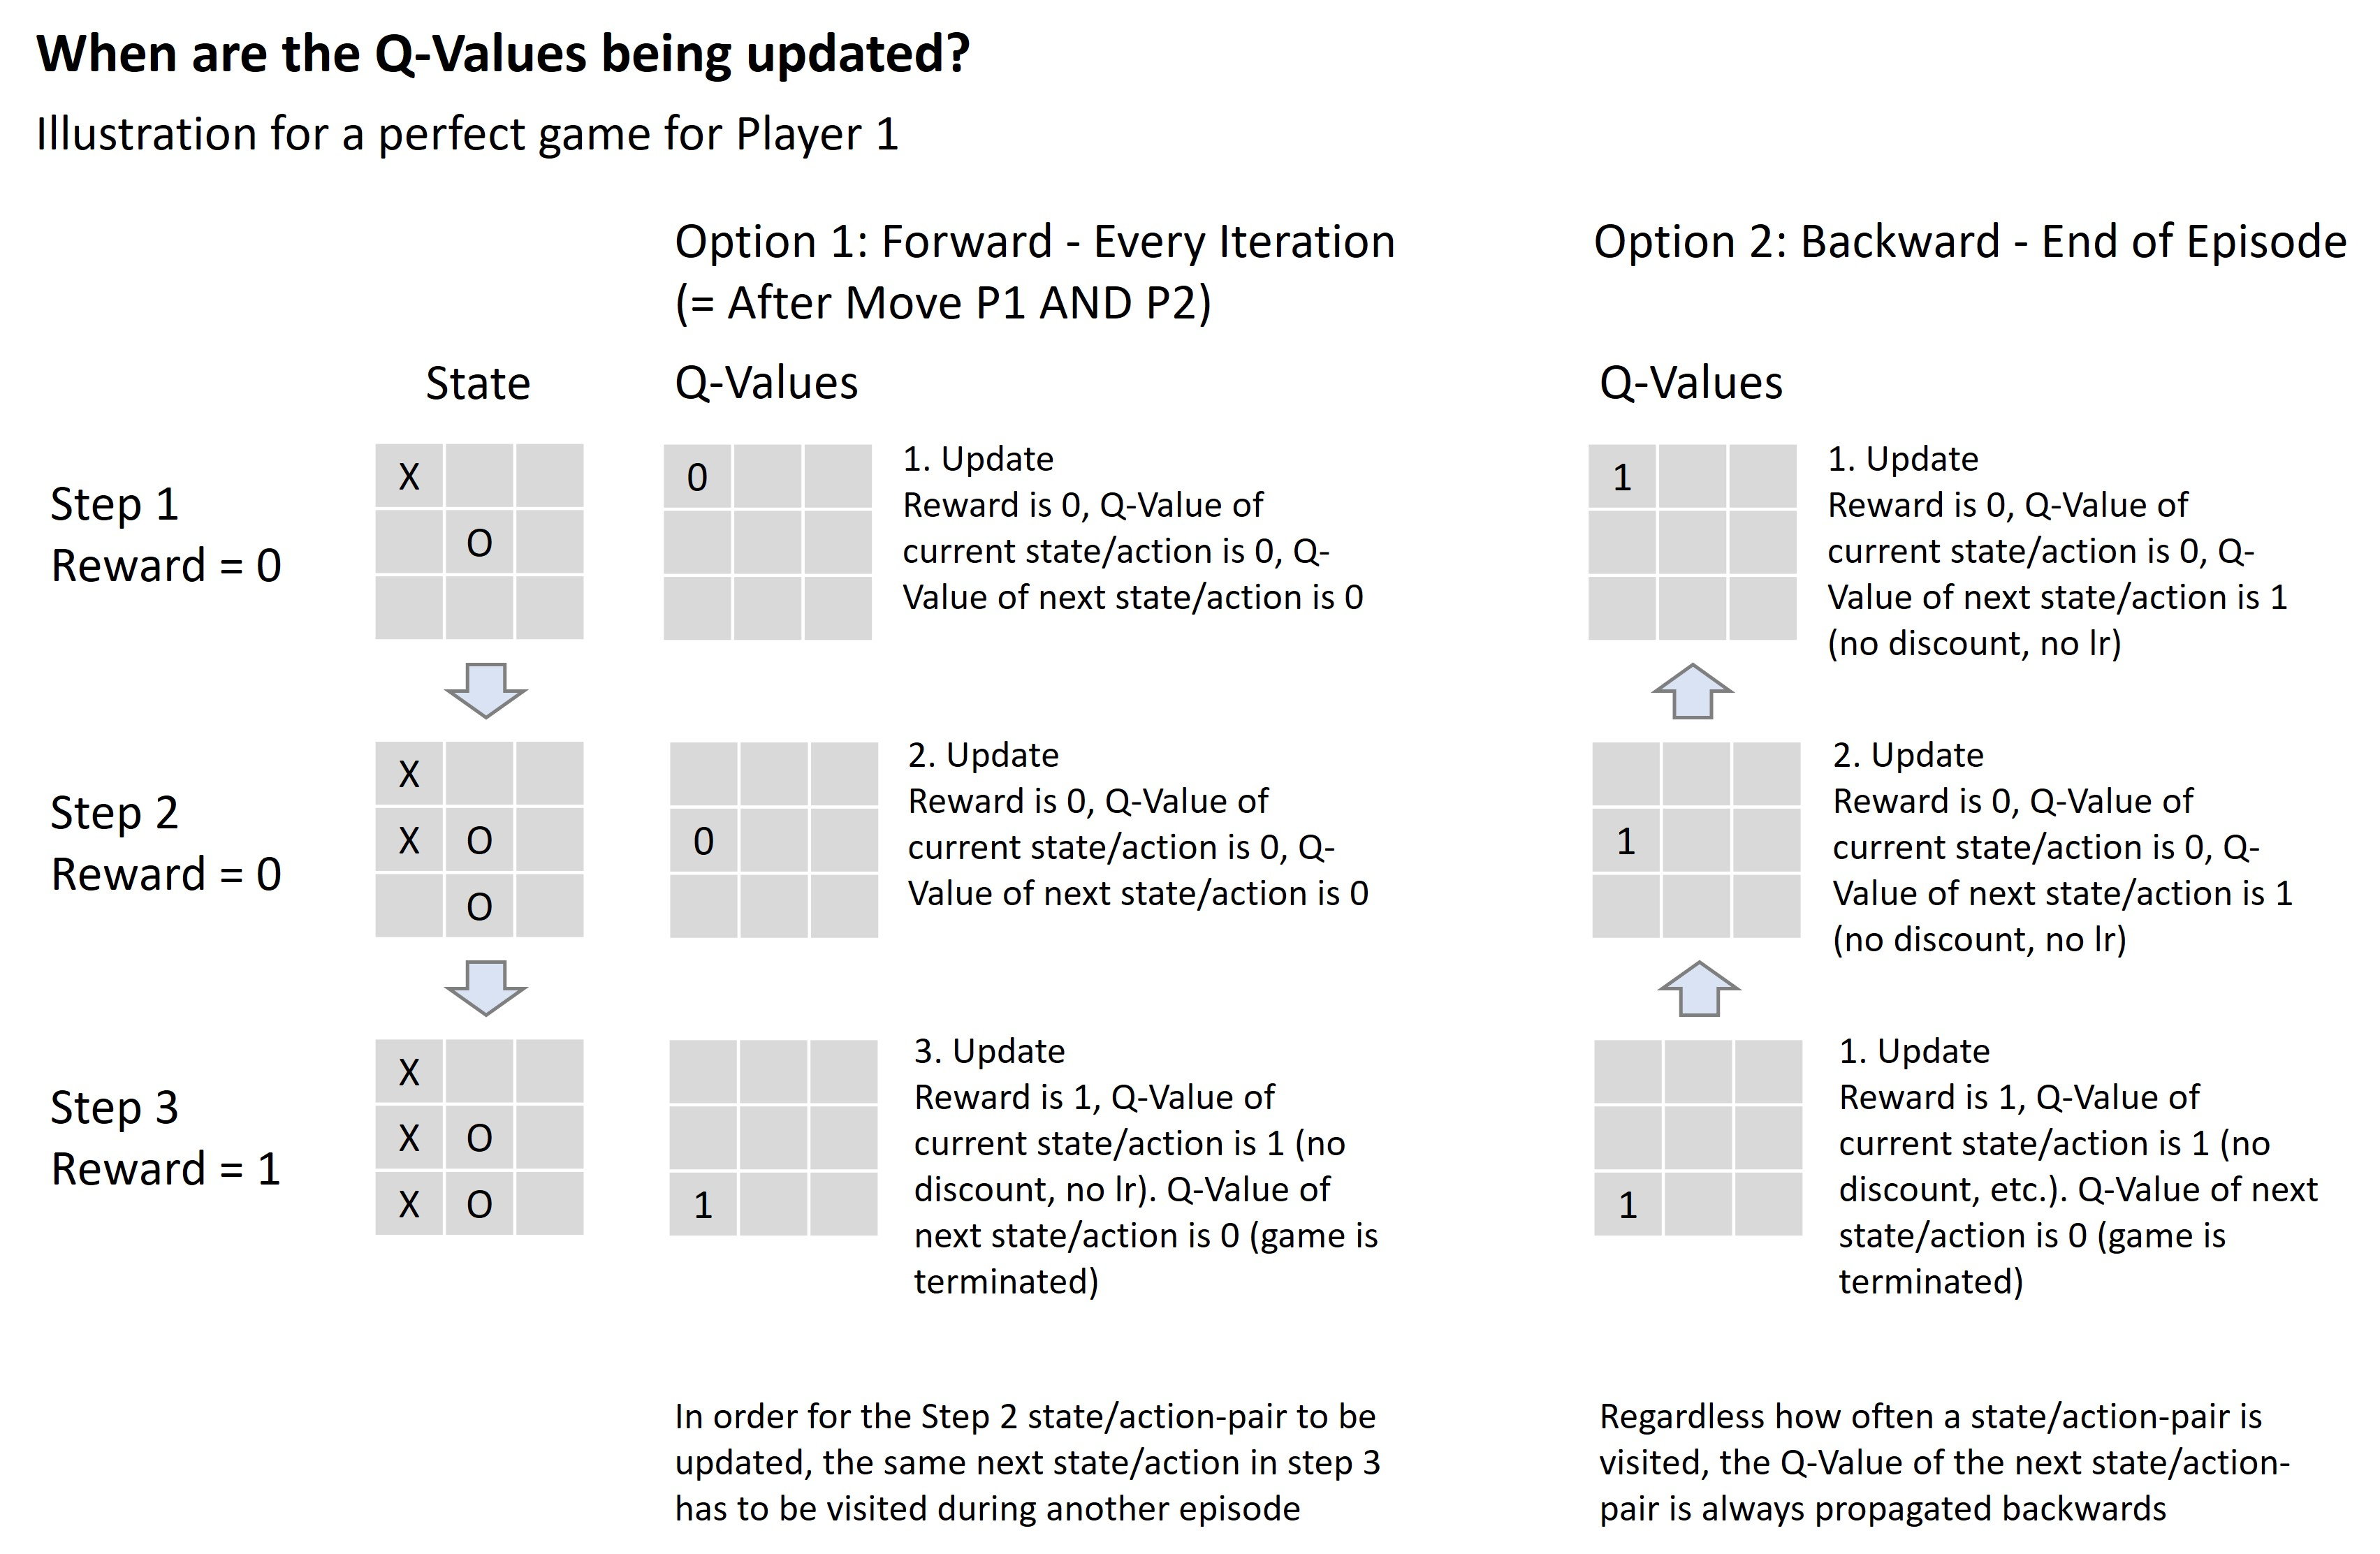

Q-Learning Algorithm for Tabular Q-Learning (Sutton & Barton, 2020):
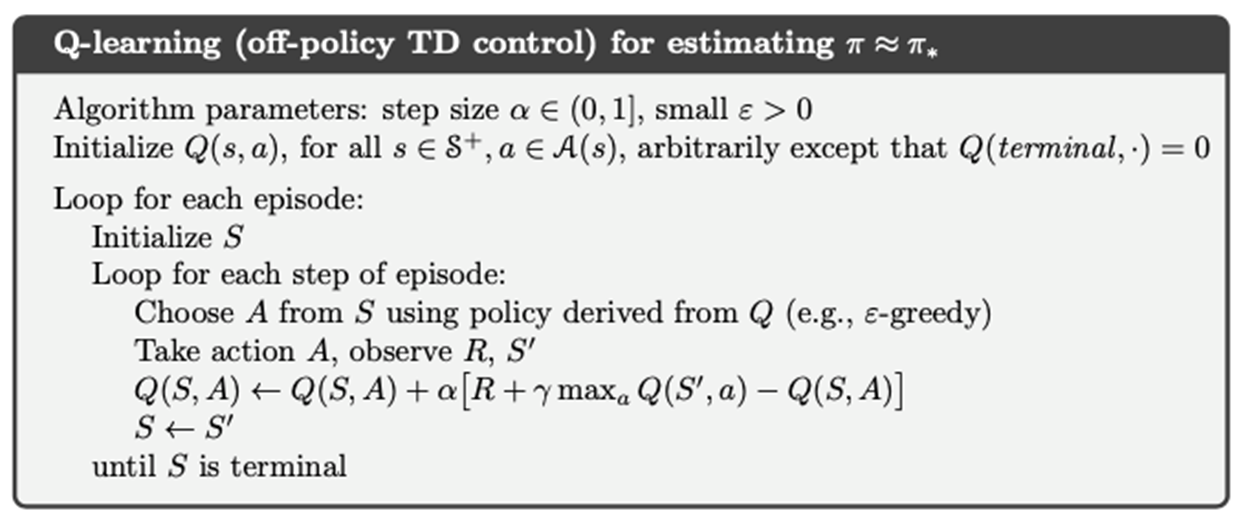

In [27]:
class TicTacToeEnv:
    
    def __init__(self, dim):
        
        self.dim = dim
        self.current_state = np.zeros(shape=(self.dim*self.dim), dtype='int')
        
    def reset(self):
        
        self.__init__(self.dim)
    
    def get_current_state(self):
        
        return self.current_state
    
    def get_possible_actions(self):
        
        return np.argwhere(self.current_state==0)
    
    def evaluate_state(self, state):
        
        # Possible returns:
        # Terminated = True, Player 1 Wins
        # Terminated = True, Player 2 Wins
        # Terminated = True, Draw
        # Terminated = False, Open
        state_to_evaluate = state.reshape(3,3)
        
        for player in [1,2]:
    
            # Win for player in a row
            for x in range(0,3):
                if state_to_evaluate[0][x] == player and state_to_evaluate[1][x] == player and state_to_evaluate[2][x] == player:
                    return True, player

            # Win for player in a column
            for y in range(0,3):
                if state_to_evaluate[y][0] == player and state_to_evaluate[y][1] == player and state_to_evaluate[y][2] == player:
                    return True, player

            # Win for player in diagonal from top left to bottom right
            if state_to_evaluate[0][0] == player and state_to_evaluate[1][1] == player and state_to_evaluate[2][2] == player:
                    return True, player

            # Win for player in diagonal from bottom left to top right
            if state_to_evaluate[0][2] == player and state_to_evaluate[1][1] == player and state_to_evaluate[2][0] == player:
                    return True, player

        if np.any(state_to_evaluate==0) == True:
            return False, 'Open'
        else:
            return True, 'Draw'
        
    # Generalized evaluation function for board sizes like 5x5 or 7x7
    def evaluate_large_state(self, state):
        
        # Possible returns:
        # Terminated = True, Player 1 Wins
        # Terminated = True, Player 2 Wins
        # Terminated = True, Draw
        # Terminated = False, Open
        state_to_evaluate = state.reshape(self.dim, self.dim)
        
        for player in [1,2]:
    
            # Win for player in a row
            for x in range(0, self.dim):
                
                num_matches = 0
                
                for y in range(0, self.dim):
                    if state_to_evaluate[y][x] == player:
                        num_matches += 1
                        
                if num_matches == self.dim:
                    return True, player

            # Win for player in a column
            for y in range(0, self.dim):
                
                num_matches = 0
                
                for x in range(0, self.dim):
                    if state_to_evaluate[y][x] == player:
                        num_matches += 1
                        
                if num_matches == self.dim:
                    return True, player

            # Win for player in diagonal from top left to bottom right
            num_matches = 0
            
            for i in range(0, self.dim):
                if state_to_evaluate[i][i] == player:
                    num_matches += 1
                    
            if num_matches == self.dim:
                return True, player
            
            # Win for player in diagonal from top right to bottom left
            num_matches = 0
            
            for i in range(0, self.dim):
                if state_to_evaluate[i][self.dim-1-i] == player:
                    num_matches += 1
                    
            if num_matches == self.dim:
                return True, player

        if np.any(state_to_evaluate==0) == True:
            return False, 'Open'
        else:
            return True, 'Draw'
              
    def evaluate_action(self, action):
        
        if self.current_state[action] == 0:
            return True
        else:
            return False
        
    def step(self, player, action):

        action_legal = self.evaluate_action(action)
        self.player = player
        self.action_p1 = action

        if action_legal:
            self.current_state[self.action_p1] = self.player
            self.terminal_state, self.terminal_reason = self.evaluate_state(self.current_state)     
        else:
            self.terminal_state = True
            self.terminal_reason = 'Illegal'

        if not self.terminal_state:
            self.player = 2

            self.action_idx = np.random.randint(0, len(self.get_possible_actions()))
            self.action_p2 = board.get_possible_actions()[self.action_idx][0]
            self.current_state[self.action_p2] = self.player

            self.terminal_state, self.terminal_reason = self.evaluate_state(self.current_state)

        if self.terminal_state:      
            if self.terminal_reason == 'Illegal':
                self.reward = -1
            elif self.terminal_reason == 1: # Win Player 1
                self.reward = 1
            elif self.terminal_reason == 2: # Win Player 2
                self.reward = -1
            elif self.terminal_reason == 'Draw':
                self.reward = 0.5
        else:
            self.reward = 0
        
        return self.current_state, self.action_p1, self.reward, self.terminal_state, self.terminal_reason

In [28]:
class TabQLearningAgent:
    
    def __init__(self, dim, player, discount, lr, epsilon, epsilon_decay, epsilon_min, min_episode_before_greedy, states_unique_dict):
        
        self.states_unique_dict = states_unique_dict
        self.dim = dim
        #!!! Init Q-Table with zeros
        self.Q = np.zeros(shape=(len(states_unique_dict), self.dim*self.dim))
        self.player = player
        self.discount = discount
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.min_episode_before_greedy = min_episode_before_greedy
    
    def get_player(self):
        
        return self.player
    
    def get_state_idx(self, state):
        
        idx = [k for k, v in self.states_unique_dict.items() if v == state] 
        
        return idx[0]
    
    def act(self, current_state, board, optimal, only_legal_moves, episode):
        
        self.current_state = current_state
        self.optimal = optimal
        self.only_legal_moves = only_legal_moves
        self.idx_current_state = self.get_state_idx(list(self.current_state))
        self.episode = episode
        
        if self.episode >= self.min_episode_before_greedy:
            self.greedy = True
            self.decay = True
        else:
            self.greedy = False
            self.decay = False
        
        if self.greedy:
            if np.random.rand() >= self.epsilon:
                #!!! Select max action from Q-Table
                self.action = np.argmax(self.Q[self.idx_current_state, :])
            else:
                if self.only_legal_moves:
                    self.action_idx = np.random.randint(0, len(board.get_possible_actions()))
                    self.action = board.get_possible_actions()[self.action_idx][0]
                else:
                    self.action = np.random.randint(self.dim*self.dim)
        elif self.optimal:
            self.action = np.argmax(self.Q[self.idx_current_state, :])
        else:
            if self.only_legal_moves:
                self.action_idx = np.random.randint(0, len(board.get_possible_actions()))
                self.action = board.get_possible_actions()[self.action_idx][0]
            else:
                self.action = np.random.randint(self.dim*self.dim)
        
        return self.action
    
    def train(self, current_state, action, reward, next_state):
                   
        self.current_state = current_state
        self.action = action
        self.reward = reward
        self.next_state = next_state

        self.idx_current_state = self.get_state_idx(list(self.current_state))
        self.idx_next_state = self.get_state_idx(list(self.next_state))
        
        #!!! Train: Update Q-Table for state/action-Pair
        self.Q[self.idx_current_state, self.action] += self.lr*(self.reward+self.discount*np.max(self.Q[self.idx_next_state, :])-self.Q[self.idx_current_state, self.action])
 
        if self.decay:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
        
    def get_qtable(self):
        
        return self.Q

In [29]:
# Experiment definitions
experiments_tabular = [
    {
        'id': 1,
        'name': 'Random',
        'min_episode_before_greedy': 10001, # > n_episodes, agent plays always random
        'discount': 0.99,
        'lr': 0.9,
        'only_legal_moves': False
    },
    {
        'id': 2,
        'name': 'Random Only Legal',
        'min_episode_before_greedy': 10001, # > n_episodes, agent plays always random
        'discount': 0.99,
        'lr': 0.9,
        'only_legal_moves': True
    },
    {
        'id': 3,
        'name': 'Tabular Greedy 0',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.9,
        'only_legal_moves': False
    },
    {
        'id': 4,
        'name': 'Tabular Greedy 10',
        'min_episode_before_greedy': 10,
        'discount': 0.99,
        'lr': 0.9,
        'only_legal_moves': False
    },
    {
        'id': 5,    
        'name': 'Tabular Greedy 2500',
        'min_episode_before_greedy': 2500,
        'discount': 0.99,
        'lr': 0.9,
        'only_legal_moves': False
    },
    {
        'id': 6,
        'name': 'Tabular Greedy 5000',
        'min_episode_before_greedy': 5000,
        'discount': 0.99,
        'lr': 0.9,
        'only_legal_moves': False
    },
    {
        'id': 7,
        'name': 'Tabular Only Legal',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.9,
        'only_legal_moves': True
    },
    {
        'id': 8,
        'name': 'Tabular Low LR',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.1,
        'only_legal_moves': False
    },
    {
        'id': 9,        
        'name': 'Tabular Low Discount',
        'min_episode_before_greedy': 0,
        'discount': 0.2,
        'lr': 0.9,
        'only_legal_moves': False
    }
]

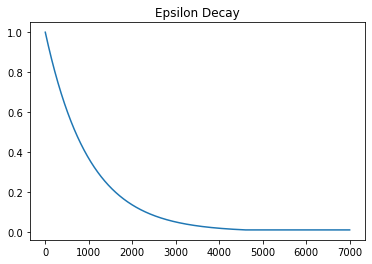

In [45]:
# Show epsilons decay configuration
# After approx. 700 iterations epsilon of 0.5 is reached, i.e. we start to predict more action, than taking random ones
epsilon = 1.0
epsilon_decay = 0.999
epsilon_min = 0.01

epsilons = []

for i in range(7000):
    
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
        
    epsilons.append(epsilon)

plt.title('Epsilon Decay')
plt.plot(np.array(epsilons))
plt.show()

In [93]:
%%time

experiments_stats = []

for experiment in experiments_tabular:
    
    experiment_id = experiment['id']
    experiment_name = experiment['name']
    print('Experiment:', experiment_name)

    # Training loop config
    dim = 3
    board = TicTacToeEnv(dim)
    n_episodes = 7000
    min_episode_before_greedy = experiment['min_episode_before_greedy']

    # Player config
    epsilon = 1.0
    epsilon_decay = 0.999
    epsilon_min = 0.01
    discount = experiment['discount']
    lr = experiment['lr']
    optimal = False
    only_legal_moves = experiment['only_legal_moves']

    player1 = TabQLearningAgent(dim, 1, discount, lr, epsilon, epsilon_decay, epsilon_min, min_episode_before_greedy, states_unique_dict)

    # Run training
    for episode in tqdm(range(1, n_episodes+1)):

        board.reset()
        terminal_state = False
        steps = []

        while not terminal_state:

            state = board.get_current_state().copy()
            action = player1.act(state, board, optimal, only_legal_moves, episode)
            next_state, action, reward, terminal_state, terminal_reason = board.step(player1.get_player(), action)
            step = next_state.copy()
            player1.train(state, action, reward, next_state)
            steps.append(step)

        episode_summary = {
            'experiment_id': experiment_id,
            'experiment_name': experiment_name,
            'episode': episode,
            'terminal_reason': terminal_reason,
            'reward': reward,
            'steps': steps
        }

        experiments_stats.append(episode_summary)
        
        if episode % 100 == 0: # Save Q-Table every 100th episode
            np.save(f'models/tabular/qtable_{experiment_id}_{episode}', player1.get_qtable())

df_experiments_stats_tabular = pd.DataFrame(experiments_stats)
df_experiments_stats_tabular.head()

Experiment: Random


100%|██████████| 7000/7000 [00:29<00:00, 235.76it/s]


Experiment: Random Only Legal


100%|██████████| 7000/7000 [00:42<00:00, 165.36it/s]


Experiment: Tabular Greedy 0


100%|██████████| 7000/7000 [00:35<00:00, 199.45it/s]


Experiment: Tabular Greedy 10


100%|██████████| 7000/7000 [00:36<00:00, 192.86it/s]


Experiment: Tabular Greedy 2500


100%|██████████| 7000/7000 [00:40<00:00, 173.95it/s]


Experiment: Tabular Greedy 5000


100%|██████████| 7000/7000 [00:34<00:00, 204.99it/s]


Experiment: Tabular Only Legal


100%|██████████| 7000/7000 [00:42<00:00, 166.33it/s]


Experiment: Tabular Low LR


100%|██████████| 7000/7000 [00:39<00:00, 175.41it/s]


Experiment: Tabular Low Discount


100%|██████████| 7000/7000 [00:38<00:00, 181.62it/s]


CPU times: total: 5min 38s
Wall time: 5min 38s


experiment_id experiment_name  episode terminal_reason  reward  \
0              1          Random        1         Illegal    -1.0   
1              1          Random        2         Illegal    -1.0   
2              1          Random        3         Illegal    -1.0   
3              1          Random        4         Illegal    -1.0   
4              1          Random        5         Illegal    -1.0   

                                               steps  
0  [[1, 0, 0, 0, 0, 0, 0, 2, 0], [1, 0, 0, 2, 0, ...  
1  [[1, 0, 0, 2, 0, 0, 0, 0, 0], [1, 2, 0, 2, 1, ...  
2  [[2, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 2, ...  
3  [[0, 2, 0, 0, 0, 0, 1, 0, 0], [0, 2, 0, 0, 0, ...  
4  [[0, 2, 0, 1, 0, 0, 0, 0, 0], [2, 2, 0, 1, 1, ...

In [94]:
df_experiments_stats_tabular.groupby(['experiment_name', 'terminal_reason']).count()

experiment_id  episode  reward  steps
experiment_name      terminal_reason                                       
Random               1                          594      594     594    594
                     2                          480      480     480    480
                     Draw                        17       17      17     17
                     Illegal                   5909     5909    5909   5909
Random Only Legal    1                         4030     4030    4030   4030
                     2                         2033     2033    2033   2033
                     Draw                       937      937     937    937
Tabular Greedy 0     1                         5230     5230    5230   5230
                     2                          179      179     179    179
                     Draw                       271      271     271    271
                     Illegal                   1320     1320    1320   1320
Tabular Greedy 10    1                         5262     5262    5262   5262
                     2                          155      155     155    155
                     Draw                       243      243     243    243
                     Illegal                   1340     1340    1340   1340
Tabular Greedy 2500  1                         3358     3358    3358   3358
                     2                          346      346     346    346
                     Draw                       107      107     107    107
                     Illegal                   3189     3189    3189   3189
Tabular Greedy 5000  1                         1506     1506    1506   1506
                     2                          433      433     433    433
                     Draw                        13       13      13     13
                     Illegal                   5048     5048    5048   5048
Tabular Low Discount 1                         5400     5400    5400   5400
                     2                          115      115     115    115
                     Draw                       306      306     306    306
                     Illegal                   1179     1179    1179   1179
Tabular Low LR       1                         5436     5436    5436   5436
                     2                          130      130     130    130
                     Draw                       391      391     391    391
                     Illegal                   1043     1043    1043   1043
Tabular Only Legal   1                         5515     5515    5515   5515
                     2                          168      168     168    168
                     Draw                       590      590     590    590
                     Illegal                    727      727     727    727

In [95]:
n_moving = 200
df_experiments_stats_tabular['rolling_avg'] = df_experiments_stats_tabular.groupby(['experiment_name'])['reward'].rolling(n_moving).mean().droplevel(0)
df_experiments_stats_tabular.head()

experiment_id experiment_name  episode terminal_reason  reward  \
0              1          Random        1         Illegal    -1.0   
1              1          Random        2         Illegal    -1.0   
2              1          Random        3         Illegal    -1.0   
3              1          Random        4         Illegal    -1.0   
4              1          Random        5         Illegal    -1.0   

                                               steps  rolling_avg  
0  [[1, 0, 0, 0, 0, 0, 0, 2, 0], [1, 0, 0, 2, 0, ...          NaN  
1  [[1, 0, 0, 2, 0, 0, 0, 0, 0], [1, 2, 0, 2, 1, ...          NaN  
2  [[2, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 2, ...          NaN  
3  [[0, 2, 0, 0, 0, 0, 1, 0, 0], [0, 2, 0, 0, 0, ...          NaN  
4  [[0, 2, 0, 1, 0, 0, 0, 0, 0], [2, 2, 0, 1, 1, ...          NaN

In [96]:
# Save experiments
df_experiments_stats_tabular.to_pickle('df_experiments_stats_tabular.pkl')

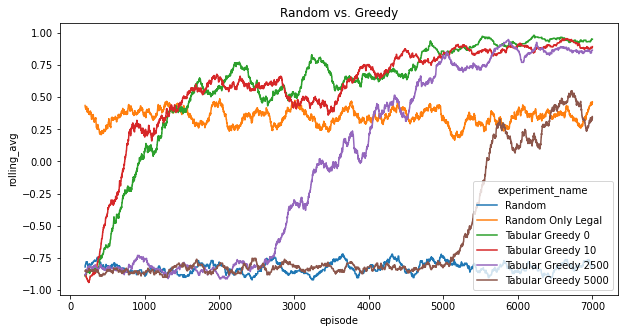

In [97]:
# Random vs. Greedy
experiment_list = ['Random', 'Random Only Legal', 'Tabular Greedy 0', 'Tabular Greedy 10', 'Tabular Greedy 2500', 'Tabular Greedy 5000']
df_subexperiment_stats = df_experiments_stats_tabular[df_experiments_stats_tabular['experiment_name'].isin(experiment_list)]

plt.figure(figsize=(10,5))
sns.lineplot(data=df_subexperiment_stats, x='episode', y='rolling_avg', hue='experiment_name')
plt.title('Random vs. Greedy')
plt.show()

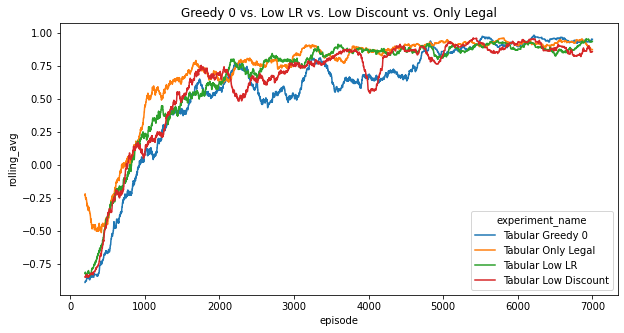

In [98]:
# Greedy 10 vs. Low LR vs. Low Discount vs. Only Legal
experiment_list = ['Tabular Greedy 0', 'Tabular Only Legal', 'Tabular Low LR', 'Tabular Low Discount']
df_subexperiment_stats = df_experiments_stats_tabular[df_experiments_stats_tabular['experiment_name'].isin(experiment_list)]

plt.figure(figsize=(10,5))
sns.lineplot(data=df_subexperiment_stats, x='episode', y='rolling_avg', hue='experiment_name')
plt.title('Greedy 0 vs. Low LR vs. Low Discount vs. Only Legal')
plt.show()

In [99]:
first_episodes = df_experiments_stats_tabular[df_experiments_stats_tabular['experiment_name']=='Tabular Greedy 0'].head(n_moving)[['terminal_reason', 'experiment_name']].groupby('terminal_reason').count()
last_episodes = df_experiments_stats_tabular[df_experiments_stats_tabular['experiment_name']=='Tabular Greedy 0'].tail(n_moving)[['terminal_reason', 'experiment_name']].groupby('terminal_reason').count()
first_episodes.rename(columns={'experiment_name': 'first_episodes'}, inplace=True)
last_episodes.rename(columns={'experiment_name': 'last_episodes'}, inplace=True)
all_episodes = pd.concat([first_episodes, last_episodes], axis=1)
all_episodes

first_episodes  last_episodes
terminal_reason                               
1                          11.0          189.0
2                           9.0            NaN
Illegal                   180.0            3.0
Draw                        NaN            8.0

In [101]:
for step in df_experiments_stats_tabular[df_experiments_stats_tabular['experiment_name']=='Tabular Greedy 0'].iloc[-1]['steps']:
    print_state(step.reshape(3,3))

[['X' '-' '-']
 ['-' '-' '-']
 ['-' '-' 'O']]
[['X' '-' 'X']
 ['-' '-' '-']
 ['O' '-' 'O']]
[['X' 'X' 'X']
 ['-' '-' '-']
 ['O' '-' 'O']]


In [102]:
qtables = []
episode_range = np.linspace(100, 7000, 70, dtype='int')

for episode in episode_range:
    qtables.append(np.load(f'models/tabular/qtable_3_{episode}.npy')) # ID 3 = Tabular Greedy 0
    
qtables = np.array(qtables)
qtables.shape

(70, 5478, 9)

In [105]:
example_state = [1, 2, 0, 0, 0, 0, 0, 0, 0]
example_idx = get_state_idx(example_state)
print('Index: ', example_idx)
print_state(np.array(example_state).reshape(3,3))

Index:  10
[['X' 'O' '-']
 ['-' '-' '-']
 ['-' '-' '-']]


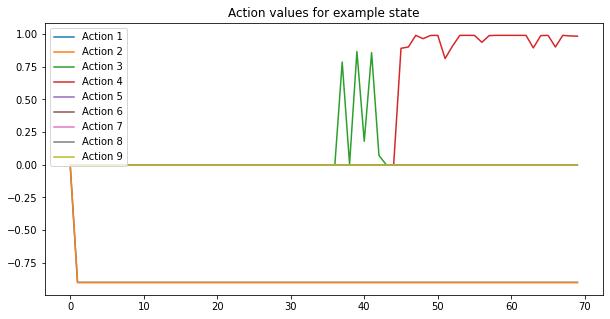

In [107]:
qa = np.empty(shape=(qtables.shape[0], qtables.shape[2]))
actions = [f'Action {i}' for i in range(1,10)]
 
for idx, qtable in enumerate(qtables):
    
    for action in range(9):
        qa[idx][action] = qtable[example_idx][action] # value of each action in state
        
plt.figure(figsize=(10,5))
plt.plot(qa)
plt.legend(actions, loc='upper left')
plt.title('Action values for example state')
plt.show()

## 3. Deep Q-Learning (without target network)
Algorithm follows Graesser & Keng (2020), with memory replay, but without target network:
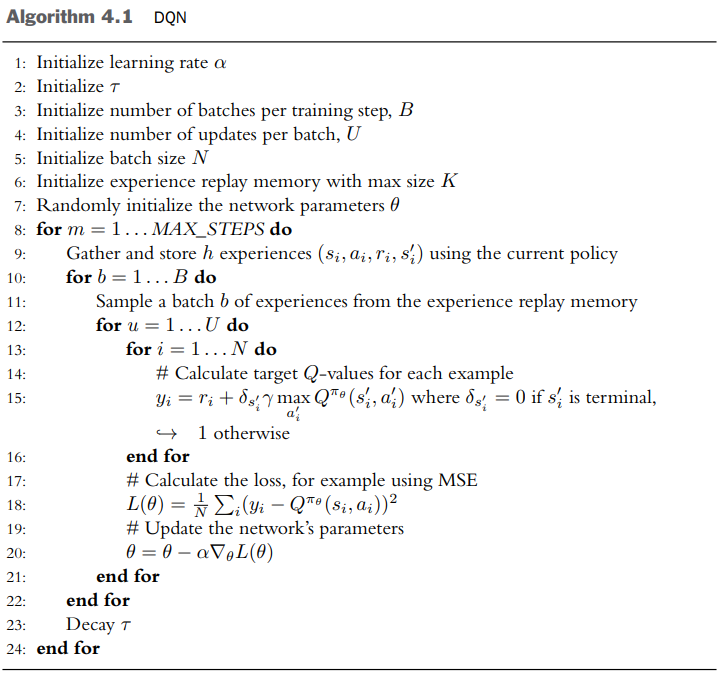

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [112]:
class DQN(nn.Module):
    
    def __init__(self, dim):
        
        super().__init__()
        
        self.dim = dim
        
        # For one hot use input dim*dim*3
        self.h1 = nn.Linear(self.dim*self.dim*3, 16)
        #self.h1 = nn.Linear(self.dim*self.dim, 16)
        self.out = nn.Linear(16, self.dim*self.dim)
    
    def forward(self, x):
        
        x = x.to(device) # Bring to GPU if available
        x = self.h1(x)
        x = F.relu(x)
        
        return self.out(x)

In [113]:
class DQNAgent:
    
    def __init__(self, dim, model, player, discount, lr, epsilon, epsilon_decay, epsilon_min, min_episode_before_greedy, max_exp_size):
        
        self.dim = dim
        self.player = player
        self.discount = discount
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.min_episode_before_greedy = min_episode_before_greedy
        self.max_mem_size = max_exp_size
        self.experiences = deque(maxlen=max_exp_size)     
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
 
    def get_player(self):
        
        return self.player
    
    def act(self, current_state, board, optimal, only_legal_moves, episode):
        
        # One Hot: 
        self.current_state = get_one_hot_state(current_state)
        #self.current_state = current_state
        self.current_state = torch.from_numpy(self.current_state).float().to(device)
        self.optimal = optimal
        self.only_legal_moves = only_legal_moves
        self.episode = episode
        
        if self.episode >= self.min_episode_before_greedy:
            self.greedy = True
            self.decay = True
        else:
            self.greedy = False
            self.decay = False
        
        if self.greedy:
            if np.random.rand() >= self.epsilon:            
                with torch.no_grad():
                    self.action = int(torch.argmax(self.model(self.current_state)).cpu().data.numpy()) 
            else:
                if self.only_legal_moves:
                    self.action_idx = np.random.randint(0, len(board.get_possible_actions()))
                    self.action = board.get_possible_actions()[self.action_idx][0]
                else:
                    self.action = np.random.randint(self.dim*self.dim)
        elif self.optimal:
            self.action = int(torch.argmax(self.model(self.current_state)).data.numpy())
        else:
            if self.only_legal_moves:
                self.action_idx = np.random.randint(0, len(board.get_possible_actions()))
                self.action = board.get_possible_actions()[self.action_idx][0]
            else:
                self.action = np.random.randint(self.dim*self.dim)
        
        return self.action
    
    def _get_batch(self, batch_size):
        
        self.batch = random.sample(self.experiences, batch_size)

        current_batch = torch.from_numpy(np.empty(shape=(batch_size, self.dim*self.dim), dtype='float'))
        target_batch = torch.from_numpy(np.empty(shape=(batch_size, self.dim*self.dim), dtype='float'))

        for idx, item in enumerate(self.batch):

            item_state = torch.from_numpy(item[0]).float()
            item_action = torch.from_numpy(np.array(item[1]))
            item_reward = torch.from_numpy(np.array(item[2]))
            item_next_state = torch.from_numpy(item[3]).float()
            item_terminal_state = torch.from_numpy(np.array(item[4]))

            # Calc new target q-value for action on state, based on next_state
            if item_terminal_state:
                target_q_v = item_reward      
            elif not item_terminal_state:
                target_q_v = item_reward + self.discount * torch.amax(self.model(item_next_state))

            # Predict current q-value of current state
            current_q = self.model(item_state)
            target_q = self.model(item_state)

            # Update current q_value of specific action with new target_q
            target_q[item_action] = target_q_v

            # Add new input and target to batch
            current_batch[idx] = current_q
            target_batch[idx] = target_q
            
        return current_batch.to(device), target_batch.to(device)
    
    def train(self, training_iter, batch_size):
        
        if len(self.experiences) >= batch_size:
            
            for iter in range(training_iter):
                       
                current_batch, target_batch = self._get_batch(batch_size)
                
                self.optimizer.zero_grad()
                loss = self.criterion(current_batch, target_batch)
                loss.backward()
                self.optimizer.step()

                #print(f'Iteration: {iter}, Loss: {loss.item()}')

            if self.decay:
                if self.epsilon > self.epsilon_min:
                    self.epsilon *= self.epsilon_decay
        
    def add_experience(self, state, action, reward, next_state, terminal_state):
        
        # One Hot: 
        self.experiences.append((get_one_hot_state(state), action, reward, get_one_hot_state(next_state), terminal_state))
        #self.experiences.append((state, action, reward, next_state, terminal_state))
        
    def get_experiences(self):
        
        return self.experiences

In [114]:
# Experiment definitions
experiments_dqn = [
    {
        'id': 1,
        'name': 'DQN Memory 1000 End-of-Step',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.001,
        'only_legal_moves': False,
        'batch_size': 32,
        'max_exp_size': 1000,
        'training_iter': 3,
        'train_each_step': True
    },
    {
        'id': 2,
        'name': 'DQN Memory 100 End-of-Step',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.001,
        'only_legal_moves': False,
        'batch_size': 32,
        'max_exp_size': 100,
        'training_iter': 3,
        'train_each_step': True
    },
    {
        'id': 3,
        'name': 'DQN Memory 1 End-of-Step',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.001,
        'only_legal_moves': False,
        'batch_size': 1,
        'max_exp_size': 1,
        'training_iter': 1,
        'train_each_step': True
    },
    {
        'id': 4,
        'name': 'DQN Memory 1000 End-of-Episode',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.001,
        'only_legal_moves': False,
        'batch_size': 32,
        'max_exp_size': 1000,
        'training_iter': 3,
        'train_each_step': False
    },
    {
        'id': 5,
        'name': 'DQN Memory 1 End-of-Episode',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.001,
        'only_legal_moves': False,
        'batch_size': 1,
        'max_exp_size': 1,
        'training_iter': 1,
        'train_each_step': False
    }
]

In [115]:
%%time

experiments_stats = []

for experiment in experiments_dqn:
    
    experiment_id = experiment['id']
    experiment_name = experiment['name']
    print('Experiment:', experiment_name)

    # Training loop config
    dim = 3 # 3x3 or 5x5 TicTacToe Board
    board = TicTacToeEnv(dim)
    n_episodes = 7000
    min_episode_before_greedy = experiment['min_episode_before_greedy']
    train_each_step = experiment['train_each_step']

    # Player config
    epsilon = 1.0
    epsilon_decay = 0.999
    epsilon_min = 0.01
    discount = experiment['discount']
    lr = experiment['lr']
    training_iter = experiment['training_iter']
    batch_size = experiment['batch_size']
    max_exp_size = experiment['max_exp_size']
    optimal = False
    only_legal_moves = experiment['only_legal_moves']

    model = DQN(dim).to(device) # Bring to GPU if available
    player1 = DQNAgent(dim, model, 1, discount, lr, epsilon, epsilon_decay, epsilon_min, min_episode_before_greedy, max_exp_size)

    # Run training
    for episode in tqdm(range(1, n_episodes+1)):

        board.reset()
        terminal_state = False

        while not terminal_state:

            state = board.get_current_state().copy()
            action = player1.act(state, board, optimal, only_legal_moves, episode) # Player 1 selects action
            next_state, action, reward, terminal_state, terminal_reason = board.step(player1.get_player(), action) # Perform action on board
            next_state = next_state.copy()
            player1.add_experience(state, action, reward, next_state, terminal_state)
            
            if train_each_step:
                player1.train(training_iter, batch_size)
                
        if not train_each_step:
            player1.train(training_iter, batch_size)

        episode_summary = {
            'experiment_id': experiment_id,
            'experiment_name': experiment_name,
            'episode': episode,
            'terminal_reason': terminal_reason,
            'reward': reward
        }

        experiments_stats.append(episode_summary)
        
        if episode % 100 == 0: # Save DQN model every 100th episode
            torch.save(model.state_dict(), f'models/dqn/dqn_{experiment_id}_{episode}.pth')

df_experiments_stats_dqn = pd.DataFrame(experiments_stats)
df_experiments_stats_dqn.head()

Experiment: DQN Memory 1000 End-of-Step


100%|██████████| 7000/7000 [20:58<00:00,  5.56it/s]


Experiment: DQN Memory 100 End-of-Step


100%|██████████| 7000/7000 [20:55<00:00,  5.58it/s]


Experiment: DQN Memory 1 End-of-Step


100%|██████████| 7000/7000 [00:32<00:00, 216.71it/s]


Experiment: DQN Memory 1000 End-of-Episode


100%|██████████| 7000/7000 [07:50<00:00, 14.89it/s]


Experiment: DQN Memory 1 End-of-Episode


100%|██████████| 7000/7000 [00:10<00:00, 637.20it/s]

CPU times: total: 49min 46s
Wall time: 50min 27s


experiment_id              experiment_name  episode terminal_reason  reward
0              1  DQN Memory 1000 End-of-Step        1         Illegal    -1.0
1              1  DQN Memory 1000 End-of-Step        2         Illegal    -1.0
2              1  DQN Memory 1000 End-of-Step        3         Illegal    -1.0
3              1  DQN Memory 1000 End-of-Step        4         Illegal    -1.0
4              1  DQN Memory 1000 End-of-Step        5         Illegal    -1.0

In [116]:
df_experiments_stats_dqn.groupby(['experiment_name', 'terminal_reason']).count()

experiment_id  episode  reward
experiment_name                terminal_reason                                
DQN Memory 1 End-of-Episode    1                         4922     4922    4922
                               2                          427      427     427
                               Draw                         3        3       3
                               Illegal                   1648     1648    1648
DQN Memory 1 End-of-Step       1                         5734     5734    5734
                               2                          320      320     320
                               Draw                        24       24      24
                               Illegal                    922      922     922
DQN Memory 100 End-of-Step     1                         5868     5868    5868
                               2                          313      313     313
                               Draw                        56       56      56
                               Illegal                    763      763     763
DQN Memory 1000 End-of-Episode 1                         5445     5445    5445
                               2                          342      342     342
                               Draw                       211      211     211
                               Illegal                   1002     1002    1002
DQN Memory 1000 End-of-Step    1                         6086     6086    6086
                               2                          277      277     277
                               Draw                       184      184     184
                               Illegal                    453      453     453

In [117]:
n_moving = 200
df_experiments_stats_dqn['rolling_avg'] = df_experiments_stats_dqn.groupby(['experiment_name'])['reward'].rolling(n_moving).mean().droplevel(0)
df_experiments_stats_dqn.head()

experiment_id              experiment_name  episode terminal_reason  \
0              1  DQN Memory 1000 End-of-Step        1         Illegal   
1              1  DQN Memory 1000 End-of-Step        2         Illegal   
2              1  DQN Memory 1000 End-of-Step        3         Illegal   
3              1  DQN Memory 1000 End-of-Step        4         Illegal   
4              1  DQN Memory 1000 End-of-Step        5         Illegal   

   reward  rolling_avg  
0    -1.0          NaN  
1    -1.0          NaN  
2    -1.0          NaN  
3    -1.0          NaN  
4    -1.0          NaN

In [118]:
# Save experiments
df_experiments_stats_dqn.to_pickle('df_experiments_stats_dqn.pkl')

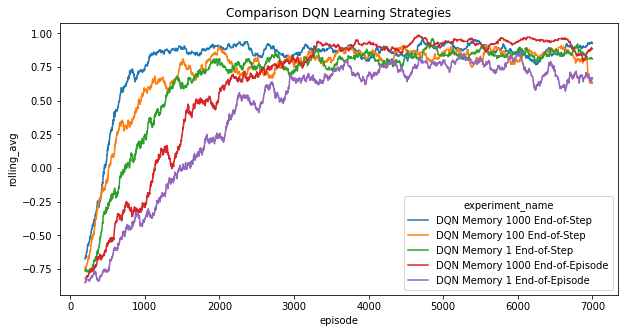

In [120]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_experiments_stats_dqn, x='episode', y='rolling_avg', hue='experiment_name')
plt.title('Comparison DQN Learning Strategies')
plt.show()

In [121]:
first_episodes = df_experiments_stats_dqn[df_experiments_stats_dqn['experiment_name']=='DQN Memory 1000 End-of-Step'].head(n_moving)[['terminal_reason', 'experiment_name']].groupby('terminal_reason').count()
last_episodes = df_experiments_stats_dqn[df_experiments_stats_dqn['experiment_name']=='DQN Memory 1000 End-of-Step'].tail(n_moving)[['terminal_reason', 'experiment_name']].groupby('terminal_reason').count()
first_episodes.rename(columns={'experiment_name': 'first_episodes'}, inplace=True)
last_episodes.rename(columns={'experiment_name': 'last_episodes'}, inplace=True)
all_episodes = pd.concat([first_episodes, last_episodes], axis=1)
all_episodes

first_episodes  last_episodes
terminal_reason                               
1                            31            188
2                            16              2
Draw                          2              6
Illegal                     151              4

[['X' 'O' '-']
 ['-' '-' '-']
 ['-' '-' '-']]
One hot state:  [1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1]


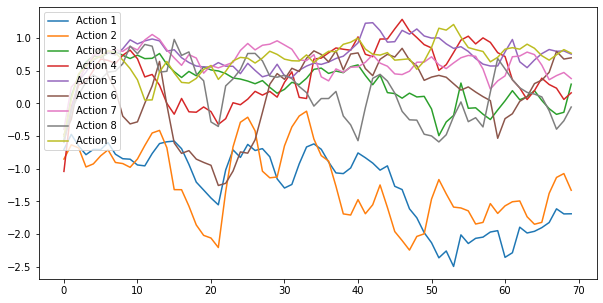

In [124]:
example_state = np.array([1, 2, 0, 0, 0, 0, 0, 0, 0])
example_state_one_hot = get_one_hot_state(example_state)
print_state(example_state.reshape(3,3))
print('One hot state: ', example_state_one_hot)

episode_range = np.linspace(100, 7000, 70, dtype='int')
qa = np.empty(shape=(len(episode_range), 9))
actions = [f'Action {i}' for i in range(1,10)]

for idx, episode in enumerate(episode_range):
    
    model.load_state_dict(torch.load(f'models/dqn/dqn_1_{episode}.pth')) # Load states for every 100th episode of best model
    pred = model(torch.from_numpy(example_state_one_hot).float()).cpu().data.numpy()
    
    for action in range(9):
        qa[idx][action] = pred[action] # value of each action
        
plt.figure(figsize=(10,5))
plt.plot(qa)
plt.legend(actions, loc='upper left')
plt.show()

## 4. SARSA (with Neural Network)

Algorithm follows Graesser & Keng (2020). Same as Sutton & Barto (2020), but with Memory and Batch - whereas Batch 1 is the same as Sutton & Barto (2020), i.e. train after each step.
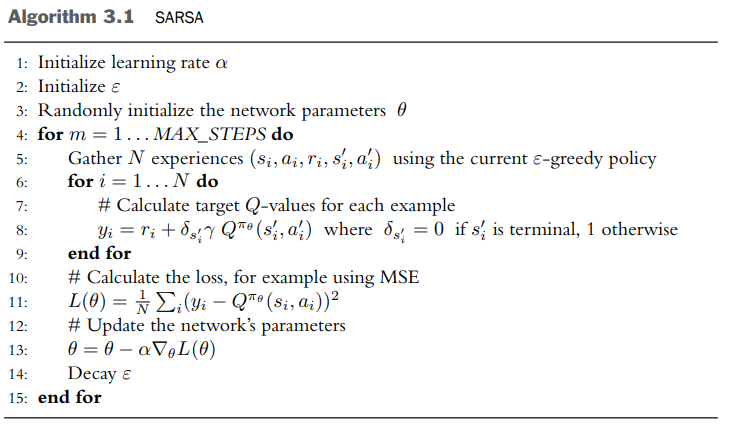

Sutton & Barto (2020):
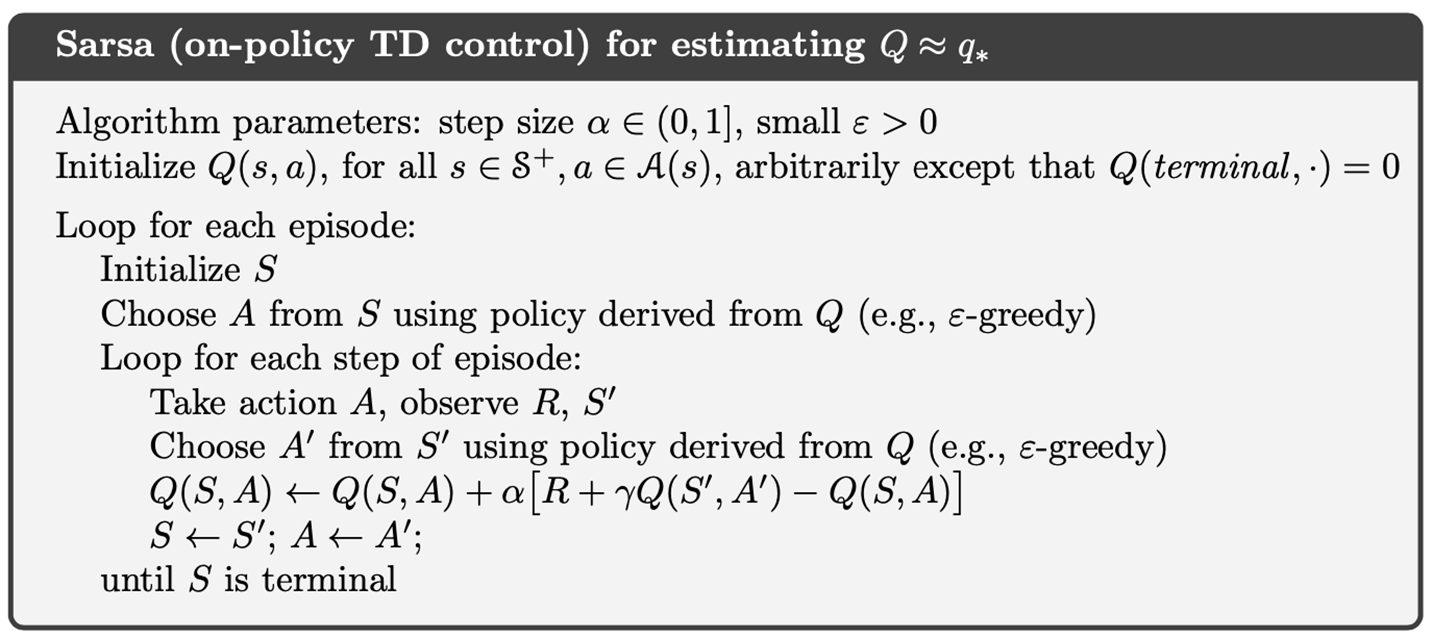

In [127]:
class SARSA(nn.Module):
    
    def __init__(self, dim):
        
        super().__init__()
        
        self.dim = dim
        
        # For one hot use input dim*dim*3
        self.h1 = nn.Linear(self.dim*self.dim*3, 16)
        #self.h1 = nn.Linear(self.dim*self.dim, 16)
        self.out = nn.Linear(16, self.dim*self.dim)
    
    def forward(self, x):
        
        x = x.to(device) # Bring to GPU if available
        x = self.h1(x)
        x = F.relu(x)
        
        return self.out(x)

In [128]:
class SARSAAgent:
    
    def __init__(self, dim, model, player, discount, lr, epsilon, epsilon_decay, epsilon_min, min_episode_before_greedy, batch_size):
        
        self.dim = dim
        self.player = player
        self.discount = discount
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.min_episode_before_greedy = min_episode_before_greedy
        self.batch_size = batch_size
        self.experiences = deque(maxlen=batch_size)     
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
 
    def get_player(self):
        
        return self.player
    
    def act(self, current_state, board, optimal, only_legal_moves, episode):
        
        # One Hot: 
        self.current_state = get_one_hot_state(current_state)
        #self.current_state = current_state
        self.current_state = torch.from_numpy(self.current_state).float().to(device)
        self.optimal = optimal
        self.only_legal_moves = only_legal_moves
        self.episode = episode
        
        if self.episode >= self.min_episode_before_greedy:
            self.greedy = True
            self.decay = True
        else:
            self.greedy = False
            self.decay = False
        
        if self.greedy:
            if np.random.rand() >= self.epsilon:            
                with torch.no_grad():
                    self.action = int(torch.argmax(self.model(self.current_state)).cpu().data.numpy()) 
            else:
                if self.only_legal_moves:
                    self.action_idx = np.random.randint(0, len(board.get_possible_actions()))
                    self.action = board.get_possible_actions()[self.action_idx][0]
                else:
                    self.action = np.random.randint(self.dim*self.dim)
        elif self.optimal:
            self.action = int(torch.argmax(self.model(self.current_state)).data.numpy())
        else:
            if self.only_legal_moves:
                self.action_idx = np.random.randint(0, len(board.get_possible_actions()))
                self.action = board.get_possible_actions()[self.action_idx][0]
            else:
                self.action = np.random.randint(self.dim*self.dim)
        
        return self.action
    
    def _get_batch(self):
        
        current_batch = torch.from_numpy(np.empty(shape=(self.batch_size, self.dim*self.dim), dtype='float'))
        target_batch = torch.from_numpy(np.empty(shape=(self.batch_size, self.dim*self.dim), dtype='float'))

        for idx, item in enumerate(self.experiences):

            item_state = torch.from_numpy(item[0]).float()
            item_action = torch.from_numpy(np.array(item[1]))
            item_reward = torch.from_numpy(np.array(item[2]))
            item_next_state = torch.from_numpy(item[3]).float()
            item_action_next_state = torch.from_numpy(np.array(item[4]))
            item_terminal_state = torch.from_numpy(np.array(item[5]))

            # Calc new target q-value for action on state, based on next_state
            if item_terminal_state:
                target_q_v = item_reward      
            elif not item_terminal_state:
                
                # All predictions - model returns Q-Values in next_state for all possible actions
                target_q_v_preds = self.model(item_next_state) 
                
                # Select the Q-Value of the selected next action (on policy)
                target_q_v_nextaction = target_q_v_preds[item_action_next_state]
                target_q_v = item_reward + self.discount * target_q_v_nextaction

            # Predict current q-value of current state
            current_q = self.model(item_state)
            target_q = self.model(item_state)

            # Update current q_value of specific action with new target_q
            target_q[item_action] = target_q_v

            # Add new input and target to batch
            current_batch[idx] = current_q
            target_batch[idx] = target_q
            
        return current_batch.to(device), target_batch.to(device)
    
    def train(self):
        
        # Train only if there is enough experiences collected under current policy
        if len(self.experiences) >= self.batch_size:
         
            current_batch, target_batch = self._get_batch() # Get complete memory

            self.optimizer.zero_grad()
            loss = self.criterion(current_batch, target_batch)
            loss.backward()
            self.optimizer.step()

            #print(f'Iteration: {iter}, Loss: {loss.item()}')

            if self.decay:
                if self.epsilon > self.epsilon_min:
                    self.epsilon *= self.epsilon_decay
                    
            #!!! Reset memory - we need to drop away all experiences under the now OLD policy since we updated the network
            self._reset_experiences()
        
    def add_experience(self, state, action, reward, next_state, next_action, terminal_state):
        
        # One Hot: 
        self.experiences.append((get_one_hot_state(state), action, reward, get_one_hot_state(next_state), next_action, terminal_state))
        #self.experiences.append((state, action, reward, next_state, next_action, terminal_state))
        
    def get_experiences(self):
        
        return self.experiences
    
    def _reset_experiences(self):
        
        self.experiences = deque(maxlen=self.batch_size)

In [129]:
# Experiment definitions
experiments_sarsa = [
    {
        'id': 1,
        'name': 'SARSA Batch 1',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.001,
        'only_legal_moves': False,
        'batch_size': 1
    },
    {
        'id': 2,
        'name': 'SARSA Batch 16',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.001,
        'only_legal_moves': False,
        'batch_size': 16
    },
    {
        'id': 3,
        'name': 'SARSA Batch 64',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.001,
        'only_legal_moves': False,
        'batch_size': 64
    },
    {
        'id': 4,
        'name': 'SARSA Batch 128',
        'min_episode_before_greedy': 0,
        'discount': 0.99,
        'lr': 0.001,
        'only_legal_moves': False,
        'batch_size': 128
    }
]

In [130]:
%%time

experiments_stats = []

for experiment in experiments_sarsa:
    
    experiment_id = experiment['id']
    experiment_name = experiment['name']
    print('Experiment:', experiment_name)

    # Training loop config
    dim = 3 # 3x3 or 5x5 TicTacToe Board
    board = TicTacToeEnv(dim)
    n_episodes = 20000
    min_episode_before_greedy = experiment['min_episode_before_greedy']

    # Player config
    epsilon = 1.0
    epsilon_decay = 0.999
    epsilon_min = 0.01
    discount = experiment['discount']
    lr = experiment['lr']
    batch_size = experiment['batch_size']
    optimal = False
    only_legal_moves = experiment['only_legal_moves']

    model = SARSA(dim).to(device) # Bring to GPU if available
    player1 = SARSAAgent(dim, model, 1, discount, lr, epsilon, epsilon_decay, epsilon_min, min_episode_before_greedy, batch_size)

    # Run training
    # Training Loop follows the algorithm described in Sutton & Barto (2020, p. 130), with the exception that a memory is added
    for episode in tqdm(range(1, n_episodes+1)):

        board.reset()
        terminal_state = False
        
        # Initial state and initial action
        state = board.get_current_state().copy()
        action = player1.act(state, board, optimal, only_legal_moves, episode)

        while not terminal_state:
            
            # Make move on board and get next_state
            next_state, action, reward, terminal_state, terminal_reason = board.step(player1.get_player(), action) # Perform action on board
            next_state = next_state.copy()
            
            # Choose next_action based on epsilon greedy, but without making move on board
            next_action = player1.act(next_state, board, optimal, only_legal_moves, episode) # Player 1 selects action, without doing the step on board
            
            # Add s, a, r, s', a', terminal_state to memory
            player1.add_experience(state, action, reward, next_state, next_action, terminal_state)
            
            # state = next_state, action = next_action
            state = next_state
            action = next_action

            # Train player - if batch_size is reached is determined in train()... when agent is trained, memory is being reseted
            player1.train()

        episode_summary = {
            'experiment_id': experiment_id,
            'experiment_name': experiment_name,
            'episode': episode,
            'terminal_reason': terminal_reason,
            'reward': reward
        }

        experiments_stats.append(episode_summary)
        
        if episode % 100 == 0: # Save SARSA model every 100th episode
            torch.save(model.state_dict(), f'models/sarsa/sarsa_{experiment_id}_{episode}.pth')

df_experiments_stats_sarsa = pd.DataFrame(experiments_stats)
df_experiments_stats_sarsa.head()

Experiment: SARSA Batch 1


100%|██████████| 20000/20000 [01:16<00:00, 259.82it/s]


Experiment: SARSA Batch 16


100%|██████████| 20000/20000 [00:45<00:00, 442.96it/s]


Experiment: SARSA Batch 64


100%|██████████| 20000/20000 [00:42<00:00, 472.76it/s]


Experiment: SARSA Batch 128


100%|██████████| 20000/20000 [00:52<00:00, 380.85it/s]


CPU times: total: 3min 36s
Wall time: 3min 37s


experiment_id experiment_name  episode terminal_reason  reward
0              1   SARSA Batch 1        1         Illegal    -1.0
1              1   SARSA Batch 1        2         Illegal    -1.0
2              1   SARSA Batch 1        3               1     1.0
3              1   SARSA Batch 1        4         Illegal    -1.0
4              1   SARSA Batch 1        5         Illegal    -1.0

In [131]:
df_experiments_stats_sarsa.groupby(['experiment_name', 'terminal_reason']).count()

experiment_id  episode  reward
experiment_name terminal_reason                                
SARSA Batch 1   1                        17894    17894   17894
                2                          536      536     536
                Draw                       316      316     316
                Illegal                   1254     1254    1254
SARSA Batch 128 1                         3172     3172    3172
                2                         1768     1768    1768
                Draw                        67       67      67
                Illegal                  14993    14993   14993
SARSA Batch 16  1                        13664    13664   13664
                2                         1036     1036    1036
                Draw                       211      211     211
                Illegal                   5089     5089    5089
SARSA Batch 64  1                         5749     5749    5749
                2                         1673     1673    1673
                Draw                       111      111     111
                Illegal                  12467    12467   12467

In [132]:
n_moving = 200
df_experiments_stats_sarsa['rolling_avg'] = df_experiments_stats_sarsa.groupby(['experiment_name'])['reward'].rolling(n_moving).mean().droplevel(0)
df_experiments_stats_sarsa.head()

experiment_id experiment_name  episode terminal_reason  reward  rolling_avg
0              1   SARSA Batch 1        1         Illegal    -1.0          NaN
1              1   SARSA Batch 1        2         Illegal    -1.0          NaN
2              1   SARSA Batch 1        3               1     1.0          NaN
3              1   SARSA Batch 1        4         Illegal    -1.0          NaN
4              1   SARSA Batch 1        5         Illegal    -1.0          NaN

In [133]:
# Save experiments
df_experiments_stats_sarsa.to_pickle('df_experiments_stats_sarsa.pkl')

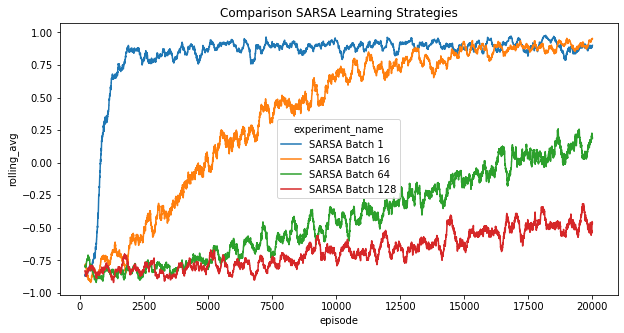

In [134]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_experiments_stats_sarsa, x='episode', y='rolling_avg', hue='experiment_name')
plt.title('Comparison SARSA Learning Strategies')
plt.show()

In [135]:
first_episodes = df_experiments_stats_sarsa[df_experiments_stats_sarsa['experiment_name']=='SARSA Batch 1'].head(n_moving)[['terminal_reason', 'experiment_name']].groupby('terminal_reason').count()
last_episodes = df_experiments_stats_sarsa[df_experiments_stats_sarsa['experiment_name']=='SARSA Batch 1'].tail(n_moving)[['terminal_reason', 'experiment_name']].groupby('terminal_reason').count()
first_episodes.rename(columns={'experiment_name': 'first_episodes'}, inplace=True)
last_episodes.rename(columns={'experiment_name': 'last_episodes'}, inplace=True)
all_episodes = pd.concat([first_episodes, last_episodes], axis=1)
all_episodes

first_episodes  last_episodes
terminal_reason                               
1                            13            190
2                            15              6
Illegal                     172              4

[['X' 'O' '-']
 ['-' '-' '-']
 ['-' '-' '-']]
One hot state:  [1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1]


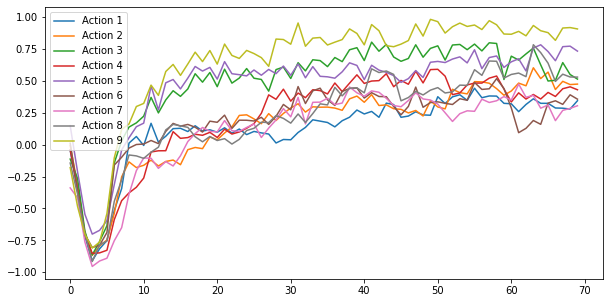

In [138]:
example_state = np.array([1, 2, 0, 0, 0, 0, 0, 0, 0])
example_state_one_hot = get_one_hot_state(example_state)
print_state(example_state.reshape(3,3))
print('One hot state: ', example_state_one_hot)

episode_range = np.linspace(100, 7000, 70, dtype='int')
qa = np.empty(shape=(len(episode_range), 9))
actions = [f'Action {i}' for i in range(1,10)]
episodes = [f'Episode {i}' for i in episode_range]

for idx, episode in enumerate(episode_range):
    
    model.load_state_dict(torch.load(f'models/sarsa/sarsa_1_{episode}.pth')) # Load states for every 100th episode of best model
    pred = model(torch.from_numpy(example_state_one_hot).float()).cpu().data.numpy()
    
    for action in range(9):
        qa[idx][action] = pred[action] # value of each action in state 0 over 9 episodes
        
plt.figure(figsize=(10,5))
plt.plot(qa)
plt.legend(actions, loc='upper left')
plt.show()

## 5. REINFORCE (with Neural Network)
Algorithm follows Graesser & Keng (2020):
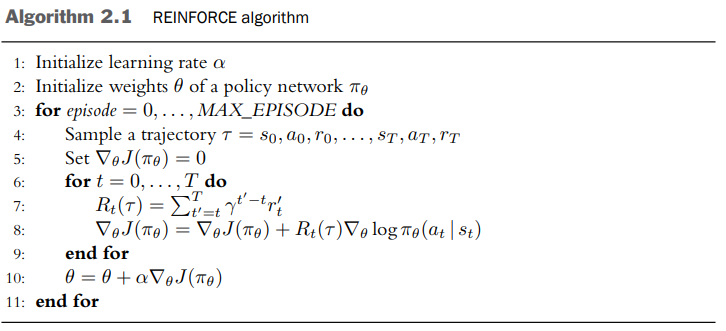

In [139]:
class REINFORCE(nn.Module):
    
    def __init__(self, dim):
        
        super().__init__()
        
        self.dim = dim
        
        # For one hot use input dim*dim*3
        self.h1 = nn.Linear(self.dim*self.dim*3, 16)
        #self.h1 = nn.Linear(self.dim*self.dim, 16)
        self.out = nn.Linear(16, self.dim*self.dim)
    
    def forward(self, x):
        
        x = x.to(device) # Bring to GPU if available
        x = self.h1(x)
        x = F.relu(x)
        
        return self.out(x)

In [297]:
class REINFORCEAgent:
    
    def __init__(self, dim, model, player, discount, lr):
        
        self.dim = dim
        self.player = player
        self.discount = discount
        self.lr = lr
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.log_probs = []
        self.rewards = []
 
    def get_player(self):
        
        return self.player
    
    def act(self, current_state, board, optimal, only_legal_moves, episode):
        
        # One Hot: 
        self.current_state = get_one_hot_state(current_state)
        #self.current_state = current_state
        self.current_state = torch.from_numpy(self.current_state).float().to(device)
        self.optimal = optimal
        self.only_legal_moves = only_legal_moves
        self.episode = episode
        
        logits = self.model(self.current_state)
        dist = Categorical(logits=logits) # Create distribution and sample from distribution
        self.action = dist.sample()
        log_prob = dist.log_prob(self.action) # Store log probability of action for training
        self.log_probs.append(log_prob) # Get log probability of the action the agent took
        
        return self.action
    
    def train(self):
        
        ### Own implementation ###
        '''
        T = len(self.rewards)
        rets = np.empty(T, dtype=np.float32)
        
        # Calculate discounted returns for each step t in episode
        for t in range(T):
            
            reward_total = 0.0

            # Return at t is calculated as sum of discounted rewards from t to T
            for i in range(t, T):
                reward_total = reward_total + self.rewards[i] * self.discount**(i-t)

            rets[t] = reward_total # Discounted total return a t

        rets = rets
        log_probs = np.array(self.log_probs)

        loss = - log_probs * rets
        loss = np.sum(loss)
        '''
        
        # Graesser & Keng (2020)
        T = len(self.rewards)
        rets = np.empty(T, dtype=np.float32)
        future_ret = 0.0
        
        # Calculate returns for each step in episode from end to beginning
        for t in reversed(range(T)):
            future_ret = self.rewards[t] + self.discount * future_ret
            rets[t] = future_ret
            
        rets = torch.tensor(rets)
        log_probs = torch.stack(self.log_probs) # Get the log probabilities of the actions taken during episode
        
        loss = - log_probs * rets # Negative because we want maximizse returns, but we use torch optimizer to minimize
        loss = torch.sum(loss)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
                    
        # Reset rewards and log_probs after training, since we are on-policy
        self.rewards = []
        self.log_probs = []
    
    def add_reward(self, reward):
        
        self.rewards.append(reward) # Store reward for training

In [265]:
rewards = [0, 0, 0, 1]
log_probs = [0.2, 0.3, 0.5, 0.4]
discount = 0.5

In [266]:
T = len(rewards)
print(T)

4


In [284]:
T = len(rewards)
rets = np.empty(T, dtype=np.float32)
future_ret = 0.0

# Calculate returns for each step in episode from end to beginning
for t in reversed(range(T)):
    future_ret = rewards[t] + discount * future_ret
    rets[t] = future_ret

rets = rets
log_probs = np.array(log_probs)

loss = - log_probs * rets       
loss = np.sum(loss)

print(loss)
print(log_probs)
print(rets)

-0.75
[0.2 0.3 0.5 0.4]
[0.125 0.25  0.5   1.   ]


In [283]:
### Own way ###
T = len(rewards)
rets = np.empty(T, dtype=np.float32)

for t in range(T):

    reward_total = 0.0 # Discounted return a t

    # Return at t is calculated as sum of discounted rewards from t to T
    for i in range(t, T):
        reward_total = reward_total + rewards[i] * discount**(i-t)

    rets[t] = reward_total # Discounted return a t

rets = rets
log_probs = np.array(log_probs)

loss = - log_probs * rets
loss = np.sum(loss)
print(loss)
print(log_probs)
print(rets)

-0.75
[0.2 0.3 0.5 0.4]
[0.125 0.25  0.5   1.   ]


In [298]:
# Experiment definitions
experiments_reinforce = [
    {
        'id': 1,
        'name': 'REINFORCE 0.001 LR 0.99 discount',
        'discount': 0.99,
        'lr': 0.001,
        'only_legal_moves': False
    },
    {
        'id': 2,
        'name': 'REINFORCE 0.01 LR 0.99 discount',
        'discount': 0.99,
        'lr': 0.01,
        'only_legal_moves': False
    },
    {
        'id': 3,
        'name': 'REINFORCE 0.01 LR 0.5 discount',
        'discount': 0.5,
        'lr': 0.01,
        'only_legal_moves': False
    },
    {
        'id': 4,
        'name': 'REINFORCE 0.01 LR 0.3 discount',
        'discount': 0.3,
        'lr': 0.01,
        'only_legal_moves': False
    }
]

In [299]:
%%time

experiments_stats = []

for experiment in experiments_reinforce:
    
    experiment_id = experiment['id']
    experiment_name = experiment['name']
    print('Experiment:', experiment_name)

    # Training loop config
    dim = 3 # 3x3 or 5x5 TicTacToe Board
    board = TicTacToeEnv(dim)
    n_episodes = 20000

    # Player config
    discount = experiment['discount']
    lr = experiment['lr']
    optimal = False
    only_legal_moves = experiment['only_legal_moves']

    model = REINFORCE(dim).to(device) # Bring to GPU if available
    player1 = REINFORCEAgent(dim, model, 1, discount, lr)

    # Run training
    for episode in tqdm(range(1, n_episodes+1)):

        board.reset()
        terminal_state = False

        while not terminal_state:

            state = board.get_current_state().copy()
            action = player1.act(state, board, optimal, only_legal_moves, episode)
            next_state, action, reward, terminal_state, terminal_reason = board.step(player1.get_player(), action)
            next_state = next_state.copy()
            player1.add_reward(reward)
            
        # Train player after every episode
        player1.train()

        episode_summary = {
            'experiment_id': experiment_id,
            'experiment_name': experiment_name,
            'episode': episode,
            'terminal_reason': terminal_reason,
            'reward': reward
        }

        experiments_stats.append(episode_summary)
        
        if episode % 100 == 0: # Save REINFORCE model every 100th episode
            torch.save(model.state_dict(), f'models/reinforce/reinforce_{experiment_id}_{episode}.pth')

df_experiments_stats_reinforce = pd.DataFrame(experiments_stats)
df_experiments_stats_reinforce.head()

Experiment: REINFORCE 0.001 LR 0.99 discount


100%|██████████| 20000/20000 [00:43<00:00, 465.02it/s]


Experiment: REINFORCE 0.01 LR 0.99 discount


100%|██████████| 20000/20000 [00:43<00:00, 455.17it/s]


Experiment: REINFORCE 0.01 LR 0.5 discount


100%|██████████| 20000/20000 [00:49<00:00, 405.21it/s]


Experiment: REINFORCE 0.01 LR 0.3 discount


100%|██████████| 20000/20000 [00:53<00:00, 371.10it/s]


CPU times: total: 3min 2s
Wall time: 3min 10s


experiment_id                   experiment_name  episode terminal_reason  \
0              1  REINFORCE 0.001 LR 0.99 discount        1         Illegal   
1              1  REINFORCE 0.001 LR 0.99 discount        2         Illegal   
2              1  REINFORCE 0.001 LR 0.99 discount        3               1   
3              1  REINFORCE 0.001 LR 0.99 discount        4         Illegal   
4              1  REINFORCE 0.001 LR 0.99 discount        5         Illegal   

   reward  
0    -1.0  
1    -1.0  
2     1.0  
3    -1.0  
4    -1.0

In [300]:
df_experiments_stats_reinforce.groupby(['experiment_name', 'terminal_reason']).count()

experiment_id  episode  \
experiment_name                  terminal_reason                           
REINFORCE 0.001 LR 0.99 discount 1                        10808    10808   
                                 2                          245      245   
                                 Draw                         7        7   
                                 Illegal                   8940     8940   
REINFORCE 0.01 LR 0.3 discount   1                        16685    16685   
                                 2                          866      866   
                                 Draw                         1        1   
                                 Illegal                   2448     2448   
REINFORCE 0.01 LR 0.5 discount   1                        16321    16321   
                                 2                          545      545   
                                 Draw                         4        4   
                                 Illegal                   3130     3130   
REINFORCE 0.01 LR 0.99 discount  1                        12008    12008   
                                 2                           49       49   
                                 Illegal                   7943     7943   

                                                  reward  
experiment_name                  terminal_reason          
REINFORCE 0.001 LR 0.99 discount 1                 10808  
                                 2                   245  
                                 Draw                  7  
                                 Illegal            8940  
REINFORCE 0.01 LR 0.3 discount   1                 16685  
                                 2                   866  
                                 Draw                  1  
                                 Illegal            2448  
REINFORCE 0.01 LR 0.5 discount   1                 16321  
                                 2                   545  
                                 Draw                  4  
                                 Illegal            3130  
REINFORCE 0.01 LR 0.99 discount  1                 12008  
                                 2                    49  
                                 Illegal            7943

In [301]:
n_moving = 200
df_experiments_stats_reinforce['rolling_avg'] = df_experiments_stats_reinforce.groupby(['experiment_name'])['reward'].rolling(n_moving).mean().droplevel(0)
df_experiments_stats_reinforce.head()

experiment_id                   experiment_name  episode terminal_reason  \
0              1  REINFORCE 0.001 LR 0.99 discount        1         Illegal   
1              1  REINFORCE 0.001 LR 0.99 discount        2         Illegal   
2              1  REINFORCE 0.001 LR 0.99 discount        3               1   
3              1  REINFORCE 0.001 LR 0.99 discount        4         Illegal   
4              1  REINFORCE 0.001 LR 0.99 discount        5         Illegal   

   reward  rolling_avg  
0    -1.0          NaN  
1    -1.0          NaN  
2     1.0          NaN  
3    -1.0          NaN  
4    -1.0          NaN

In [303]:
# Save experiments
df_experiments_stats_reinforce.to_pickle('df_experiments_stats_reinforce.pkl')

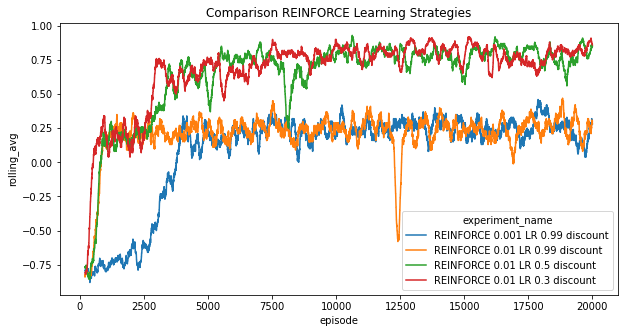

In [302]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_experiments_stats_reinforce, x='episode', y='rolling_avg', hue='experiment_name')
plt.title('Comparison REINFORCE Learning Strategies')
plt.show()

In [304]:
first_episodes = df_experiments_stats_reinforce[df_experiments_stats_reinforce['experiment_name']=='REINFORCE 0.01 LR 0.3 discount'].head(n_moving)[['terminal_reason', 'experiment_name']].groupby('terminal_reason').count()
last_episodes = df_experiments_stats_reinforce[df_experiments_stats_reinforce['experiment_name']=='REINFORCE 0.01 LR 0.3 discount'].tail(n_moving)[['terminal_reason', 'experiment_name']].groupby('terminal_reason').count()
first_episodes.rename(columns={'experiment_name': 'first_episodes'}, inplace=True)
last_episodes.rename(columns={'experiment_name': 'last_episodes'}, inplace=True)
all_episodes = pd.concat([first_episodes, last_episodes], axis=1)
all_episodes

first_episodes  last_episodes
terminal_reason                               
1                            18          186.0
2                            12            5.0
Draw                          1            NaN
Illegal                     169            9.0

[['X' 'O' '-']
 ['-' '-' '-']
 ['-' '-' '-']]
One hot state:  [1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1]


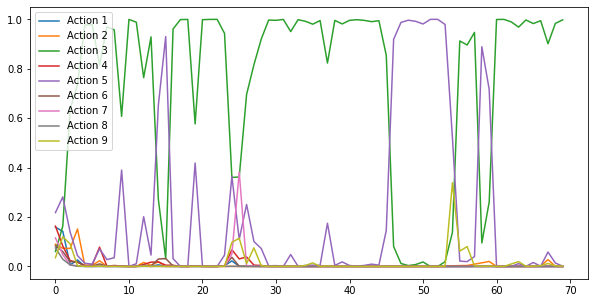

In [307]:
example_state = np.array([1, 2, 0, 0, 0, 0, 0, 0, 0])
example_state_one_hot = get_one_hot_state(example_state)
print_state(example_state.reshape(3,3))
print('One hot state: ', example_state_one_hot)

episode_range = np.linspace(100, 7000, 70, dtype='int')
qa = np.empty(shape=(len(episode_range), 9))
actions = [f'Action {i}' for i in range(1,10)]
episodes = [f'Episode {i}' for i in episode_range]

for idx, episode in enumerate(episode_range):
    
    model.load_state_dict(torch.load(f'models/reinforce/reinforce_4_{episode}.pth')) # Load states for every 100th episode of best model
    logits = model(torch.from_numpy(example_state_one_hot).float())
    dist = Categorical(logits=logits)
    pd_probs = dist.probs
    
    for action in range(9):
        qa[idx][action] = pd_probs[action] # value of each action in state 0 over 9 episodes
        
plt.figure(figsize=(10,5))
plt.plot(qa)
plt.legend(actions, loc='upper left')
plt.show()

## 6. Comparison Q-Learning, DQN, SARSA and REINFORCE

In [309]:
df_experiments_stats_tabular = pd.read_pickle('df_experiments_stats_tabular.pkl')
df_experiments_stats_dqn = pd.read_pickle('df_experiments_stats_dqn.pkl')
df_experiments_stats_sarsa = pd.read_pickle('df_experiments_stats_sarsa.pkl')
df_experiments_stats_reinforce = pd.read_pickle('df_experiments_stats_reinforce.pkl')

df_experiments_stats_sarsa = df_experiments_stats_sarsa[df_experiments_stats_sarsa['experiment_name']=='SARSA Batch 1'].iloc[:7000]
df_experiments_stats_reinforce = df_experiments_stats_reinforce[df_experiments_stats_reinforce['experiment_name']=='REINFORCE 0.01 LR 0.3 discount'].iloc[:7000]

df_experiments_all = pd.concat([df_experiments_stats_tabular, df_experiments_stats_dqn, df_experiments_stats_sarsa, df_experiments_stats_reinforce]).reset_index()
df_experiments_all.to_pickle('df_experiments_all.pkl')

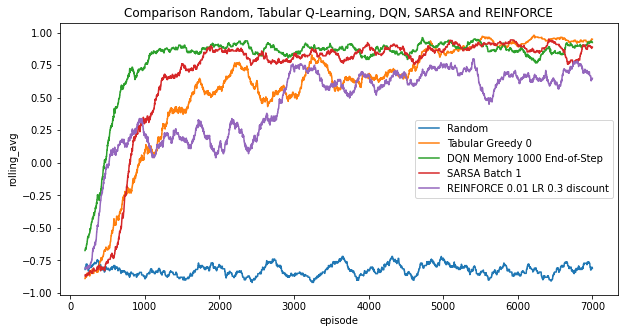

In [310]:
experiments_list = ['Random', 'Tabular Greedy 0', 'DQN Memory 1000 End-of-Step', 'SARSA Batch 1', 'REINFORCE 0.01 LR 0.3 discount']

df_subexperiment_stats = df_experiments_all[df_experiments_all['experiment_name'].isin(experiments_list)]

plt.figure(figsize=(10,5))
sns.lineplot(data=df_subexperiment_stats, x='episode', y='rolling_avg', hue='experiment_name')
plt.title('Comparison Random, Tabular Q-Learning, DQN, SARSA and REINFORCE')
plt.legend(loc='center right')
plt.show()

## Summary and further work

<b>Summary</b>
- Different agents have been trained as player 1 with Tabular Q-Learning, DQN, SARSA and REINFORCE against a random player 2
- DQN with end-of-step training with 3 batch iterations and a memory of 1000 states learns fastest, but is also the most expensive (20min training time)
- Same performance with less costs can be achieved with Tabular Q-Learning, SARSA and REINFORCE
- Training only against a random player is not enough as shown during interactive play

<b>Further Work</b>
- Train Player 2 against trained Player 1 (iterative training)
- Agent that can train Player 1 and 2 at the same time (self-play)
- Train Agent interactively against human player
- Extend TicTacToe Environment to 5x5 or 7x7 grid (with maybe different rules, e.g. 4 in a row)
- Apply CNN instead of Dense Network

## References

Graesser, L. & Keng, W.L. (2020). <i>Foundations of Deep Reinforcement Learning.</i> Addison Wesley Data & Analytics Series.   
Sutton, R.S. & Barto, A.G. (2020). <i>Reinforcement Learning: An Introduction (2nd Edition)</i>. The MIT Press.